In [1]:
! pip install -U backtrader

Requirement already up-to-date: backtrader in c:\users\meowe\anaconda3\envs\tensorflow\lib\site-packages (1.9.74.123)


In [ ]:
! pip install -U chainerrl

In [230]:
# Agent
import chainer
import chainerrl

In [231]:
# Strategy

from datetime import datetime
import backtrader
import random

# Integrate Model
import sys
import warnings
import numpy
import pandas
warnings.filterwarnings('ignore')
# Build Instance and draw single plot
#為了將GUI圖形顯示在 Jupyter notebook 
%matplotlib inline
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot

In [232]:
obs_size = 1500
n_actions = 3

# Instance of Value function Q from "chainerrl.q_functions.FCStateQFunctionWithDiscreteAction"
I_Am_Q_Function = chainerrl.q_functions.FCStateQFunctionWithDiscreteAction(obs_size, n_actions,n_hidden_layers=7, n_hidden_channels=512)

In [233]:
# Instance of training optimizer from chainer.optimizers
optimizer = chainer.optimizers.Adam(eps=1e-2)
# set the oprimizer 
optimizer.setup(I_Am_Q_Function)

In [234]:
# Set the discount factor that discounts future rewards.
gamma = 0.95

# Use epsilon-greedy for exploration
def Im_RandomInterger_Function(Interger_Range_Start=0 ,Interger_Range_End=2):
    
    return random.randint(Interger_Range_Start, Interger_Range_End)
    

explorer = chainerrl.explorers.ConstantEpsilonGreedy(epsilon=0.3, random_action_func=Im_RandomInterger_Function)

# DQN uses Experience Replay.
# Specify a replay buffer and its capacity.
replay_buffer = chainerrl.replay_buffer.ReplayBuffer(capacity=10 ** 6)

# Since observations from CartPole-v0 is numpy.float64 while
# Chainer only accepts numpy.float32 by default, specify
# a converter as a feature extractor function phi.
phi = lambda x: x.astype(numpy.float32, copy=False)

# Now create an agent that will interact with the environment.
I_am_DQN_Agent = chainerrl.agents.DoubleDQN(
    I_Am_Q_Function, optimizer, replay_buffer, gamma, explorer,
    replay_start_size=500, update_interval=1,
    target_update_interval=100, phi=phi)

In [235]:
def Function_For_Build_Customize_Object(Parameter1, Parameter2):
    
    class Customize_Object(backtrader.Strategy):
        
        
        def __init__(self):
    
            self.data_open = self.datas[0].open
            self.data_high = self.datas[0].high
            self.data_low = self.datas[0].low
            self.data_close = self.datas[0].close
            self.data_volume = self.datas[0].volume
        
            self.FeatureData_PeriodRange_Start = 0
            self.FeatureData_PeriodRange_End = -300
            
            self.Position_Value = 10000
            self.Observation_State = None
            self.Step_Reward = 0        
            self.Empirical_Reward = 0                
    
    
            
        def next(self):
            
            def Function_Make_FeatureDataSet(From_Period, To_Period) :
                
                Im_Feature_DataSet = []
                
                for TimeSequence in range( From_Period, To_Period, -1) :
                    
                    Im_Feature_DataSet.append(self.data_open[TimeSequence])
                    Im_Feature_DataSet.append(self.data_high[TimeSequence])
                    Im_Feature_DataSet.append(self.data_low[TimeSequence])
                    Im_Feature_DataSet.append(self.data_close[TimeSequence])
                    Im_Feature_DataSet.append(self.data_volume[TimeSequence])
    
                return Im_Feature_DataSet            
            
################################################################################################            
#                                      Space for Customize Strategy   
################################################################################################           


            Im_Current_Feature_DataSet = numpy.reshape(
                Function_Make_FeatureDataSet(0, self.FeatureData_PeriodRange_End - self.FeatureData_PeriodRange_Start),
                (1,1, 5*( self.FeatureData_PeriodRange_Start - self.FeatureData_PeriodRange_End) ))
            self.Observation_State = Im_Current_Feature_DataSet
            Im_Current_PositionDifference = self.broker.getvalue() - self.Position_Value
            self.Step_Reward = Im_Current_PositionDifference
            self.Empirical_Reward = self.Empirical_Reward + self.Step_Reward
            self.Position_Value = self.broker.getvalue()
            
            Action_Select = I_am_DQN_Agent.act_and_train(self.Observation_State , self.Step_Reward)
            
            
            print("============================================{}============================================".format(self.data.datetime.datetime()))
            if Action_Select == 0 :
                self.buy()
                print("Buying")                
            if Action_Select == 1 :
                self.sell()
                print("Selling")
            if Action_Select == 2 : 
                print("Holding")
            
        
            Pandas_Data = pandas.DataFrame({"Open Price": self.data_open[0],
                                    "High Price": self.data_high[0],
                                    "Low Price": self.data_low[0],
                                    "Close Price": self.data_close[0],
                                    "Volumns": self.data_volume[0],
                                    "Position": self.Position_Value,
                                    "Action": Action_Select,
                                    "Current Reward": Im_Current_PositionDifference,
                                    "Total Reward": self.Empirical_Reward},index=[0])
            
            Pannel_Data = Pandas_Data.sort_values(["Action","Current Reward","Total Reward","Position","Open Price","High Price","Low Price","Close Price","Volumns"])
            
            print(Pannel_Data) 
            
#            if (self.Trading_DateTime_End <= self.data.datetime.datetime()) :
#            
#                print("************************************************************************"*20)
#                print("Total Reward : ", self.Empirical_Reward, 'Sstatistics:', I_am_DQN_Agent.get_statistics())
#                I_am_DQN_Agent.stop_episode_and_train(self.Observation_State,  self.Step_Reward, True)     
#                print("************************************************************************"*20)            
        
################################################################################################            
#                                      Space for Customize Strategy   
################################################################################################            

    return Customize_Object
            

In [236]:
class Trading_Picture_Generator:


    # General
    Trading_Object_Name = ""
    Trading_Level_Multiplier = 1000
    
    Trading_DateTime_Start = datetime(2018,1,1)
    Trading_DateTime_End = datetime(2019,9,22)

    I_Am_Trading_Cerebro_Object = backtrader.Cerebro()
    
    # Parameter Performance Batch
    Parameter_Performance_Batch = []
    
    # Parameter for Customization Strategy
    Customization_Parameter1 = 10 
    Customization_Parameter2 = 20


    def __init__(
        self, 
        Trading_Object_Name_Input, 
        Trading_Level_Multiplier_Input, 
        Trading_DateTime_Start_Input, 
        Trading_DateTime_End_Input):

        self.Trading_Object_Name = Trading_Object_Name_Input
        self.Trading_Level_Multiplier = Trading_Level_Multiplier_Input

        self.Trading_DateTime_Start = Trading_DateTime_Start_Input
        self.Trading_DateTime_End = Trading_DateTime_End_Input


    def Function_RunTrading_Customize(self, Customization_Parameter1, Customization_Parameter2): 

        Cerebro_Object = backtrader.Cerebro()
        Cerebro_Object.broker.setcommission(mult=self.Trading_Level_Multiplier)
        Customize_StrategyObject = Function_For_Build_Customize_Object(Customization_Parameter1, Customization_Parameter2)
        Cerebro_Object.addstrategy(Customize_StrategyObject)

        Im_Data = backtrader.feeds.YahooFinanceData(
            dataname = self.Trading_Object_Name, 
            fromdate=self.Trading_DateTime_Start, 
            todate=self.Trading_DateTime_End)    

        Cerebro_Object.adddata(Im_Data)
        Cerebro_Object.broker.setcash(10000.0)
        Cerebro_Object.run()        
        
        self.Customization_Parameter1 = Customization_Parameter1
        self.Customization_Parameter2 = Customization_Parameter2                                            
        self.Trading_Cerebro_Object = Cerebro_Object


    def Function_Plotting_Customize(self) : 

    #    cerebro.plot()
        figure = matplotlib.pyplot.figure(figsize=(24.0, 15.0))
        figure = self.Trading_Cerebro_Object.plot()[0][0]
        figure.savefig('Trading_Plot/Customize/TradingCustomizeStratey_Object[{}]_Position[{}%]_Multiplier[{}].jpg'.format(
            self.Trading_Object_Name,
            self.Trading_Cerebro_Object.broker.getvalue()/100,
            self.Trading_Level_Multiplier))
        matplotlib.pyplot.close(figure)
        matplotlib.pyplot.close("all")
        
        
    def Function_Batch_MovingAverage(self, Trading_Object_Name_List, Trading_Level_Multiplier_List, Customization_Parameter1_Interval, Customization_Parameter2_Interval):

        try:

            for Specific_Trading_Object_Counter in range(len(Trading_Object_Name_List)):
                for Customization_Parameter1 in range(Customization_Parameter1_Interval[0],Customization_Parameter1_Interval[1]):
                    for Customization_Parameter2 in range(Customization_Parameter2_Interval[0] ,Customization_Parameter2_Interval[1]):

                        self.Trading_Object_Name = Trading_Object_Name_List[Specific_Trading_Object_Counter]
                        self.Trading_Level_Multiplier = Trading_Level_Multiplier_List[Specific_Trading_Object_Counter]
                        self.Function_RunTrading_Customize(Customization_Parameter1 , Customization_Parameter2)
                        self.Parameter_Performance_Batch.append([
                            self.Trading_Object_Name,
                            self.Trading_Cerebro_Object.broker.getvalue()/100,
                            self.Customization_Parameter1,
                            self.Customization_Parameter2])                                            
                        self.Function_Plotting_Customize()
                        
                    self.Function_Plotting_StrategyCombination()

        except:
            
            print(sys.exc_info())
            
            
    def Function_Plotting_StrategyCombination(self) :
        
        X_axsis = numpy.array([])
        Y_axsis = numpy.array([])
        Z_axsis = numpy.array([])
        for data in self.Parameter_Performance_Batch :
            Z_axsis = numpy.append( Z_axsis, data[1])
            Y_axsis = numpy.append( Y_axsis, data[2])
            X_axsis = numpy.append( X_axsis, data[3])
            
        print(X_axsis)        
        print(Y_axsis)
        print(Z_axsis)
        print(self.Parameter_Performance_Batch)        
        ParameterPerformance_Figure = matplotlib.pyplot.figure(figsize=(20,20))
        ax = ParameterPerformance_Figure.add_subplot(111,projection='3d')
        ax.scatter3D(X_axsis, Y_axsis, Z_axsis, c=Z_axsis, s=500, cmap='viridis')

        ParameterPerformance_Figure.savefig('Trading_Plot/Customize/TradingCustomizeStratey_Object[{}]_Parameter1[{}%]_Parameter2[{}].jpg'.format(
            self.Trading_Object_Name,
            self.Customization_Parameter1,
            self.Customization_Parameter2))        
        
        matplotlib.pyplot.show()
        matplotlib.pyplot.close(ParameterPerformance_Figure)
        matplotlib.pyplot.close("all")


In [237]:
# Customize
I_Am_Trading_Instance = Trading_Picture_Generator("TSM", 1000, datetime(2010,1,1), datetime(2020,1,1))

In [208]:
I_Am_Trading_Instance.Function_RunTrading_Customize("I_AM_Input1","I_AM_Input2")
I_Am_Trading_Instance.Function_Plotting_Customize()

============================================2017-01-03 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        26.15             0.0       26.33      25.93        26.1   

   Position  Total Reward    Volumns  
0   10000.0           0.0  7039303.0  
============================================2017-01-04 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        26.14             0.0       26.28      26.05       26.22   

   Position  Total Reward    Volumns  
0   10000.0           0.0  4922568.0  
============================================2017-01-05 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        26.59            0.24       26.68      26.34       26.35   

   Position

============================================2017-02-14 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        27.95           -4.93       28.08      27.76       28.08   

     Position  Total Reward    Volumns  
0  10181.1324      181.1324  5838082.0  
============================================2017-02-15 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        28.33            6.31       28.37       28.1        28.1   

     Position  Total Reward    Volumns  
0  10187.4424      187.4424  5130375.0  
============================================2017-02-16 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        28.84            9.21       28.99      28.22        28.3   

     

============================================2017-03-24 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        29.27            9.02       29.53      29.09        29.2   

     Position  Total Reward    Volumns  
0  10225.1224      225.1224  6612929.0  
============================================2017-03-27 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        29.59           13.12       29.67      29.25       29.31   

     Position  Total Reward    Volumns  
0  10238.2424      238.2424  6345718.0  
============================================2017-03-28 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        29.75            6.55       29.83      29.56       29.76   

    

   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        30.27           27.58       30.33      29.95       29.95   

       Position  Total Reward    Volumns  
0  13548.388526   3548.388526  6713134.0  
============================================2017-05-03 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        30.59      1896.04494       30.59      30.19       30.23   

       Position  Total Reward    Volumns  
0  15444.433466   5444.433466  7465675.0  
============================================2017-05-04 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        30.46           -7.58        30.5      30.31        30.5   

       Position  Total Reward    Volumns  
0  15436.853466   5436.853466  6385845.0  
=================================

KeyboardInterrupt: 

============================================2010-01-04 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         8.19             0.0        8.26       8.11        8.12   

   Position  Total Reward     Volumns  
0   10000.0           0.0  11452747.0  
============================================2010-01-05 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         8.15            0.05        8.24        8.1         8.2   

   Position  Total Reward     Volumns  
0  10000.05          0.05  20335395.0  
============================================2010-01-06 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         8.12            0.03        8.21       8.04        8.17   

   Pos

   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         7.11           -0.48        7.14       7.01        7.11   

       Position  Total Reward    Volumns  
0  11789.690136   1789.690136  7302885.0  
============================================2010-02-19 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.08       186.38058        7.13       7.01         7.1   

       Position  Total Reward     Volumns  
0  11976.070716   1976.070716  11394324.0  
============================================2010-02-22 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.07            0.18        7.13       7.06        7.09   

       Position  Total Reward     Volumns  
0  11976.250716   1976.250716  11914312.0  
===========================

============================================2010-03-25 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.37           -2.08        7.46       7.32        7.32   

       Position  Total Reward     Volumns  
0  12590.490413   2590.490413  27541669.0  
============================================2010-03-26 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.32            1.57        7.46        7.3        7.39   

       Position  Total Reward     Volumns  
0  12592.060413   2592.060413  18036192.0  
============================================2010-03-29 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.45           -4.06        7.45       7.35       

============================================2010-04-28 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.42            3.25         7.6       7.35        7.59   

       Position  Total Reward     Volumns  
0  11685.386786   1685.386786  27917087.0  
============================================2010-04-29 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.47           -2.27        7.49       7.39        7.45   

       Position  Total Reward     Volumns  
0  11683.116786   1683.116786  18420666.0  
============================================2010-04-30 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.49           -0.92        7.53       7.39       

============================================2010-06-01 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         6.96      408.188644        7.06       6.85        6.88   

      Position  Total Reward     Volumns  
0  12121.87543    2121.87543  30292263.0  
============================================2010-06-02 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.13          -10.81        7.13       6.93        7.03   

      Position  Total Reward     Volumns  
0  12111.06543    2111.06543  19603228.0  
============================================2010-06-03 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.01            7.82        7.17       6.96        7.1

   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.41            -5.1        7.44       7.29        7.35   

       Position  Total Reward     Volumns  
0  13029.654171   3029.654171  18221077.0  
============================================2010-07-09 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.46            -4.3        7.48       7.35        7.41   

       Position  Total Reward    Volumns  
0  13025.354171   3025.354171  7056231.0  
============================================2010-07-12 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1          7.4            5.18        7.47        7.4        7.42   

       Position  Total Reward     Volumns  
0  13030.534171   3030.534171  10961749.0  
===========================

   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.13      110.739077        7.27        7.1        7.17   

       Position  Total Reward     Volumns  
0  11735.787657   1735.787657  19381256.0  
============================================2010-08-16 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.18           -4.84        7.24       7.07        7.09   

       Position  Total Reward     Volumns  
0  11730.947657   1730.947657  10144055.0  
============================================2010-08-17 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.26           -7.71        7.29       7.15        7.23   

       Position  Total Reward     Volumns  
0  11723.237657   1723.237657  16782387.0  
=========================

   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.33          -25.42        7.35       7.14        7.21   

       Position  Total Reward     Volumns  
0  12721.266323   2721.266323  40489236.0  
============================================2010-09-27 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.27            6.71        7.33       7.26        7.32   

       Position  Total Reward     Volumns  
0  12727.976323   2727.976323  17453887.0  
============================================2010-09-28 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         7.41          -15.82        7.42       7.24        7.27   

       Position  Total Reward     Volumns  
0  12712.156323   2712.156323  16752714.0  
=========================

   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1          7.9          -10.31        7.99       7.87        7.99   

       Position  Total Reward     Volumns  
0  12159.948736   2159.948736  19208381.0  
============================================2010-10-29 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         8.01          -14.53        8.04       7.86        7.89   

       Position  Total Reward     Volumns  
0  12145.418736   2145.418736  17902955.0  
============================================2010-11-01 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2          8.0            1.33        8.08       7.97        8.01   

       Position  Total Reward    Volumns  
0  12146.748736   2146.748736  8528269.0  
===========================

============================================2010-12-02 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         8.48      -903.24364        8.51       8.24        8.24   

      Position  Total Reward     Volumns  
0  7333.666022  -2666.333978  37959112.0  
============================================2010-12-03 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         8.79          -43.36        8.82       8.48        8.52   

      Position  Total Reward     Volumns  
0  7290.306022  -2709.693978  31009056.0  
============================================2010-12-06 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         8.73            8.46        8.81       8.69        8.7

0  847.996889  -9152.003111  32583326.0  
============================================2011-01-07 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1          9.6    -1946.978927        9.62       9.46        9.48   

      Position  Total Reward     Volumns  
0 -1098.982038 -11098.982038  28032312.0  
============================================2011-01-10 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         9.71          -16.69        9.75       9.59        9.63   

      Position  Total Reward     Volumns  
0 -1115.672038 -11115.672038  22179410.0  
============================================2011-01-11 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.86     -235

============================================2011-02-10 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.43           28.69        9.52       9.36        9.49   

      Position  Total Reward     Volumns  
0 -3403.815249 -13403.815249  35870432.0  
============================================2011-02-11 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.51          -12.08        9.54       9.29        9.37   

      Position  Total Reward     Volumns  
0 -3415.895249 -13415.895249  15508681.0  
============================================2011-02-14 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.47            6.04        9.52       9.45        9.5

   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         8.77          -21.14        8.85       8.73        8.73   

      Position  Total Reward     Volumns  
0 -3304.155249 -13304.155249  20697981.0  
============================================2011-03-22 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         8.68           13.59        8.77       8.67        8.76   

      Position  Total Reward     Volumns  
0 -3290.565249 -13290.565249  14769531.0  
============================================2011-03-23 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         8.84          -24.16        8.86       8.61        8.73   

      Position  Total Reward     Volumns  
0 -3314.725249 -13314.725249  24284830.0  
===============================

   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.76          -80.03        9.81       9.29        9.43   

      Position  Total Reward     Volumns  
0 -3453.645249 -13453.645249  60538847.0  
============================================2011-04-28 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.85          -13.59         9.9       9.67        9.68   

      Position  Total Reward     Volumns  
0 -3467.235249 -13467.235249  43039924.0  
============================================2011-04-29 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         9.92          -10.57        9.92       9.79        9.83   

      Position  Total Reward     Volumns  
0 -3477.805249 -13477.805249  20924353.0  
===============================

   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        10.02            6.04       10.12       9.98       10.04   

      Position  Total Reward     Volumns  
0 -3492.905249 -13492.905249  12566918.0  
============================================2011-06-06 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        10.05           -4.53       10.14       9.98       10.01   

      Position  Total Reward     Volumns  
0 -3497.435249 -13497.435249  14417242.0  
============================================2011-06-07 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         10.2          -22.65       10.32      10.12       10.13   

      Position  Total Reward     Volumns  
0 -3520.085249 -13520.085249  20040090.0  
===============================

============================================2011-07-08 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.66           16.61        9.68       9.45        9.68   

      Position  Total Reward     Volumns  
0 -3438.545249 -13438.545249  18245974.0  
============================================2011-07-11 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.47           28.69        9.62       9.45        9.55   

      Position  Total Reward     Volumns  
0 -3409.855249 -13409.855249  13374747.0  
============================================2011-07-12 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.37            15.1        9.44       9.28        9.4

   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         8.47           49.83        8.72       8.46        8.67   

      Position  Total Reward     Volumns  
0 -3258.855249 -13258.855249  25323245.0  
============================================2011-08-11 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         8.82          -52.85        8.95       8.58        8.58   

      Position  Total Reward     Volumns  
0 -3311.705249 -13311.705249  22221013.0  
============================================2011-08-12 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         8.77            7.55        8.84       8.68        8.74   

      Position  Total Reward     Volumns  
0 -3304.155249 -13304.155249  11805079.0  
===============================

Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         9.05           16.61        9.13       8.89        9.06   

      Position  Total Reward     Volumns  
0 -3346.435249 -13346.435249  24622469.0  
============================================2011-09-15 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         9.27          -33.22        9.34       9.19        9.19   

      Position  Total Reward     Volumns  
0 -3379.655249 -13379.655249  20789806.0  
============================================2011-09-16 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1          9.5          -34.73        9.58       9.39        9.45   

      Position  Total Reward     Volumns  
0 -3414.385249 -13414.385249  20433213.0  
=======================

   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.27           12.08        9.41       9.23        9.28   

      Position  Total Reward     Volumns  
0 -3379.655249 -13379.655249  11193908.0  
============================================2011-10-20 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.04           34.73        9.22       8.91         9.2   

      Position  Total Reward     Volumns  
0 -3344.925249 -13344.925249  17467733.0  
============================================2011-10-21 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.32          -42.28        9.34       9.16        9.16   

      Position  Total Reward    Volumns  
0 -3387.205249 -13387.205249  9443855.0  
=================================

============================================2011-11-30 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         9.89           -60.4        9.92       9.71        9.78   

      Position  Total Reward     Volumns  
0 -3473.275249 -13473.275249  24799716.0  
============================================2011-12-01 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        10.11          -33.22       10.16       9.91        9.91   

      Position  Total Reward     Volumns  
0 -3506.495249 -13506.495249  14681078.0  
============================================2011-12-02 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        10.04           10.57       10.23      10.02       10.14

Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        10.06           13.59       10.11       9.98       10.07   

      Position  Total Reward    Volumns  
0 -3498.945249 -13498.945249  9648405.0  
============================================2012-01-05 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        10.15          -13.59       10.17      10.06        10.1   

      Position  Total Reward     Volumns  
0 -3512.535249 -13512.535249  13461870.0  
============================================2012-01-06 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        10.07           12.08       10.16      10.02       10.16   

      Position  Total Reward     Volumns  
0 -3500.455249 -13500.455249  10156781.0  
===========================

============================================2012-02-08 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        10.86           -15.1       10.92      10.73       10.75   

      Position  Total Reward    Volumns  
0 -3619.745249 -13619.745249  9094576.0  
============================================2012-02-09 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        10.93          -10.57       10.96      10.77       10.87   

      Position  Total Reward     Volumns  
0 -3630.315249 -13630.315249  11887894.0  
============================================2012-02-10 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         10.6           49.83       10.79      10.56       10.78 

============================================2012-03-13 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        11.38          -54.36       11.38      11.14       11.18   

      Position  Total Reward    Volumns  
0 -3698.265249 -13698.265249  8952591.0  
============================================2012-03-14 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        11.34            6.04       11.57      11.33       11.43   

      Position  Total Reward    Volumns  
0 -3692.225249 -13692.225249  8676982.0  
============================================2012-03-15 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        11.44           -15.1        11.5      11.33       11.43   

Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        11.56             0.0       11.74      11.51       11.68   

      Position  Total Reward    Volumns  
0 -3725.445249 -13725.445249  8287341.0  
============================================2012-04-17 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        11.64          -12.08       11.68      11.49        11.6   

      Position  Total Reward     Volumns  
0 -3737.525249 -13737.525249  14477443.0  
============================================2012-04-18 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         11.7           -9.06       11.76      11.47       11.61   

      Position  Total Reward    Volumns  
0 -3746.585249 -13746.585249  7874190.0  
===========================

============================================2012-05-17 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        11.25           25.67       11.43      11.23       11.35   

      Position  Total Reward     Volumns  
0 -3678.635249 -13678.635249  14729149.0  
============================================2012-05-18 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        10.93           48.32       11.35      10.93       11.21   

      Position  Total Reward     Volumns  
0 -3630.315249 -13630.315249  16553655.0  
============================================2012-05-21 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        11.04          -16.61       11.09      10.98       11.0

============================================2012-06-20 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        10.82           -3.02       10.87      10.72       10.77   

      Position  Total Reward    Volumns  
0 -3613.705249 -13613.705249  7307820.0  
============================================2012-06-21 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         10.4           63.42       10.75      10.36       10.71   

      Position  Total Reward     Volumns  
0 -3550.285249 -13550.285249  16767087.0  
============================================2012-06-22 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        10.59          -28.69       10.63      10.47        10.5   


0 -3509.515249 -13509.515249  31110243.0  
============================================2012-07-24 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        10.24          -16.61       10.24       10.0       10.04   

      Position  Total Reward     Volumns  
0 -3526.125249 -13526.125249  23033806.0  
============================================2012-07-25 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        10.32          -12.08       10.43      10.19        10.2   

      Position  Total Reward     Volumns  
0 -3538.205249 -13538.205249  25117960.0  
============================================2012-07-26 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        10.59       

0 -3699.775249 -13699.775249  9720302.0  
============================================2012-08-27 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         11.4           -1.51       11.48      11.33       11.46   

      Position  Total Reward    Volumns  
0 -3701.285249 -13701.285249  8683334.0  
============================================2012-08-28 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        11.35            7.55       11.42      11.31       11.36   

      Position  Total Reward    Volumns  
0 -3693.735249 -13693.735249  7233062.0  
============================================2012-08-29 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        11.38           -4.5

============================================2012-09-28 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        12.54          -25.67       12.55      12.35       12.37   

      Position  Total Reward     Volumns  
0 -3873.425249 -13873.425249  23072653.0  
============================================2012-10-01 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        12.61          -10.57       12.64      12.45       12.47   

      Position  Total Reward     Volumns  
0 -3883.995249 -13883.995249  24481807.0  
============================================2012-10-02 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        12.69          -12.08       12.73      12.58       12.67

============================================2012-11-05 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        12.59          -13.59        12.6       12.5       12.56   

      Position  Total Reward     Volumns  
0 -3880.975249 -13880.975249  16504751.0  
============================================2012-11-06 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        12.84          -37.75       12.91      12.59        12.6   

      Position  Total Reward     Volumns  
0 -3918.725249 -13918.725249  11060468.0  
============================================2012-11-07 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        12.82            3.02       12.87      12.66       12.7

============================================2012-12-10 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        13.38           18.12       13.54      13.35       13.45   

      Position  Total Reward     Volumns  
0 -4000.265249 -14000.265249  10106739.0  
============================================2012-12-11 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        13.63          -37.75       13.69      13.57       13.59   

      Position  Total Reward     Volumns  
0 -4038.015249 -14038.015249  13324853.0  
============================================2012-12-12 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        13.53            15.1       13.67       13.5       13.67 

============================================2013-01-15 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        14.18            15.1       14.22      14.09       14.18   

      Position  Total Reward     Volumns  
0 -4121.065249 -14121.065249  15216167.0  
============================================2013-01-16 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        14.11           10.57       14.15      14.07       14.08   

      Position  Total Reward     Volumns  
0 -4110.495249 -14110.495249  11321414.0  
============================================2013-01-17 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        14.48          -55.87       14.55      14.26       14.3

   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        15.18          -73.99       15.19      14.76        14.8   

      Position  Total Reward     Volumns  
0 -4272.065249 -14272.065249  13986109.0  
============================================2013-02-20 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        14.98            30.2       15.26      14.95       15.22   

      Position  Total Reward     Volumns  
0 -4241.865249 -14241.865249  11666356.0  
============================================2013-02-21 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        14.82           24.16       14.99      14.77       14.94   

      Position  Total Reward    Volumns  
0 -4217.705249 -14217.705249  8889162.0  
==================================

============================================2013-03-22 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        13.53          -21.14       13.55      13.38       13.41   

      Position  Total Reward    Volumns  
0 -4022.915249 -14022.915249  7387815.0  
============================================2013-03-25 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        13.44           13.59       13.65      13.42        13.6   

      Position  Total Reward     Volumns  
0 -4009.325249 -14009.325249  10762319.0  
============================================2013-03-26 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        13.53          -13.59       13.57      13.44       13.47  

============================================2013-04-25 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        14.82           -30.2       14.82      14.64       14.67   

      Position  Total Reward     Volumns  
0 -4217.705249 -14217.705249  19228090.0  
============================================2013-04-26 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        14.69           19.63       14.91      14.66       14.83   

      Position  Total Reward    Volumns  
0 -4198.075249 -14198.075249  8864064.0  
============================================2013-04-29 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        14.93          -36.24       14.95      14.76       14.78   

============================================2013-05-29 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        15.26          -24.16        15.3      15.08       15.08   

      Position  Total Reward     Volumns  
0 -4284.145249 -14284.145249  16512949.0  
============================================2013-05-30 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        15.04           33.22       15.22      15.03       15.21   

      Position  Total Reward     Volumns  
0 -4250.925249 -14250.925249  10328838.0  
============================================2013-05-31 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         14.8           36.24        15.0      14.77        15.0

============================================2013-07-02 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        14.67           -6.04       14.95      14.65       14.79   

      Position  Total Reward     Volumns  
0 -4195.055249 -14195.055249  15736421.0  
============================================2013-07-03 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        14.77           -15.1        14.8      14.61       14.69   

      Position  Total Reward    Volumns  
0 -4210.155249 -14210.155249  8156827.0  
============================================2013-07-05 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        14.84          -10.57       15.11       14.8       15.06   

============================================2013-08-05 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        13.71           -3.02       13.74      13.54       13.64   

      Position  Total Reward    Volumns  
0 -4050.095249 -14050.095249  8959037.0  
============================================2013-08-06 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        13.52           28.69        13.7       13.5       13.58   

      Position  Total Reward     Volumns  
0 -4021.405249 -14021.405249  16528132.0  
============================================2013-08-07 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        13.18           51.34       13.37      13.13       13.37 

============================================2013-09-06 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        13.86           21.14       14.09      13.85       14.04   

      Position  Total Reward    Volumns  
0 -4072.745249 -14072.745249  7776703.0  
============================================2013-09-09 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         14.1          -36.24       14.13      13.93       13.94   

      Position  Total Reward     Volumns  
0 -4108.985249 -14108.985249  11822478.0  
============================================2013-09-10 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        14.25          -22.65        14.3      14.13        14.3  

============================================2013-10-10 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         14.4          -49.83        14.4       14.2       14.21   

      Position  Total Reward     Volumns  
0 -4154.285249 -14154.285249  13123340.0  
============================================2013-10-11 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        14.74          -51.34       14.77      14.53       14.59   

      Position  Total Reward     Volumns  
0 -4205.625249 -14205.625249  14465183.0  
============================================2013-10-14 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        14.68            9.06        14.7      14.55        14.

============================================2013-11-12 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        14.52          -10.57       14.52      14.35       14.39   

      Position  Total Reward     Volumns  
0 -4172.405249 -14172.405249  10517322.0  
============================================2013-11-13 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        14.35           25.67       14.47      14.15       14.26   

      Position  Total Reward     Volumns  
0 -4146.735249 -14146.735249  15800403.0  
============================================2013-11-14 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        14.26           13.59       14.38      14.25       14.3

============================================2013-12-16 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        13.94           -3.02       14.05      13.94       13.94   

      Position  Total Reward    Volumns  
0 -4084.825249 -14084.825249  8809589.0  
============================================2013-12-17 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        13.92            3.02        14.1      13.91       14.09   

      Position  Total Reward     Volumns  
0 -4081.805249 -14081.805249  30139081.0  
============================================2013-12-18 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        13.85           10.57        13.9      13.59       13.86 

============================================2014-01-21 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        14.42            9.06       14.53      14.36       14.48   

      Position  Total Reward     Volumns  
0 -4157.305249 -14157.305249  10271803.0  
============================================2014-01-22 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        14.64          -33.22       14.65      14.44       14.48   

      Position  Total Reward     Volumns  
0 -4190.525249 -14190.525249  15792304.0  
============================================2014-01-23 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        14.43           31.71       14.62      14.35       14.51

============================================2014-02-24 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        14.42            6.04        14.5      14.38       14.43   

      Position  Total Reward    Volumns  
0 -4157.305249 -14157.305249  6747500.0  
============================================2014-02-25 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        14.36            9.06       14.44      14.34       14.38   

      Position  Total Reward    Volumns  
0 -4148.245249 -14148.245249  7294126.0  
============================================2014-02-26 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        14.53          -25.67       14.56      14.36       14.38   


============================================2014-03-27 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        15.83          -40.77       15.89      15.48       15.48   

      Position  Total Reward     Volumns  
0 -4370.215249 -14370.215249  17450590.0  
============================================2014-03-28 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        16.01          -27.18       16.22      15.85       15.85   

      Position  Total Reward     Volumns  
0 -4397.395249 -14397.395249  13799295.0  
============================================2014-03-31 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        16.32          -46.81       16.33      16.08       16.09

============================================2014-04-30 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        16.38             0.0       16.38      16.14       16.27   

      Position  Total Reward     Volumns  
0 -4453.265249 -14453.265249  15908865.0  
============================================2014-05-01 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        16.11           40.77       16.39       16.1       16.37   

      Position  Total Reward     Volumns  
0 -4412.495249 -14412.495249  12609106.0  
============================================2014-05-02 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        15.99           18.12       16.14      15.99        16.1  

============================================2014-06-03 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        17.31          -70.97       17.36      16.81       16.87   

      Position  Total Reward     Volumns  
0 -4593.695249 -14593.695249  24682385.0  
============================================2014-06-04 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         17.2           16.61       17.33      17.18       17.29   

      Position  Total Reward     Volumns  
0 -4577.085249 -14577.085249  13360395.0  
============================================2014-06-05 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        17.28          -12.08       17.29      17.16       17.21 

============================================2014-07-07 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        18.48            4.53       18.65      18.44        18.6   

      Position  Total Reward     Volumns  
0 -4770.365249 -14770.365249  15203345.0  
============================================2014-07-08 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        18.39           13.59       18.48       18.3       18.43   

      Position  Total Reward     Volumns  
0 -4756.775249 -14756.775249  12661377.0  
============================================2014-07-09 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        18.27           18.12       18.33       18.2        18.

============================================2014-08-07 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        16.59           16.61       16.86      16.56       16.75   

      Position  Total Reward     Volumns  
0 -4484.975249 -14484.975249  10385301.0  
============================================2014-08-08 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        16.49            15.1       16.69      16.43       16.64   

      Position  Total Reward     Volumns  
0 -4469.875249 -14469.875249  23742242.0  
============================================2014-08-11 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        16.71          -33.22       16.81      16.67       16.6

============================================2014-09-11 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        17.41           16.61       17.45      17.28       17.36   

      Position  Total Reward    Volumns  
0 -4608.795249 -14608.795249  8867861.0  
============================================2014-09-12 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        16.95           69.46        17.3       16.9       17.28   

      Position  Total Reward     Volumns  
0 -4539.335249 -14539.335249  18165607.0  
============================================2014-09-15 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        16.86           13.59       17.06      16.86       17.06 

============================================2014-10-14 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        16.78          -58.89       16.98      16.54       16.57   

      Position  Total Reward     Volumns  
0 -4513.665249 -14513.665249  25558633.0  
============================================2014-10-15 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        16.72            9.06       16.87      16.21       16.43   

      Position  Total Reward     Volumns  
0 -4504.605249 -14504.605249  24915121.0  
============================================2014-10-16 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        17.26          -81.54       17.57      16.82       16.8

============================================2014-11-17 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        18.26            60.4        18.5      18.15       18.47   

      Position  Total Reward     Volumns  
0 -4737.145249 -14737.145249  19573956.0  
============================================2014-11-18 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        18.37          -16.61       18.42      18.08       18.13   

      Position  Total Reward     Volumns  
0 -4753.755249 -14753.755249  16018100.0  
============================================2014-11-19 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        18.77           -60.4       18.86      18.53       18.6

0 -4722.045249 -14722.045249  12967257.0  
============================================2014-12-19 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         18.5          -51.34       18.79      18.32       18.74   

      Position  Total Reward     Volumns  
0 -4773.385249 -14773.385249  14051092.0  
============================================2014-12-22 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        18.64          -21.14       18.81      18.51       18.56   

      Position  Total Reward    Volumns  
0 -4794.525249 -14794.525249  5658240.0  
============================================2014-12-23 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        18.51          

   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        20.13          -21.14       20.16      19.91       19.96   

      Position  Total Reward     Volumns  
0 -5019.515249 -15019.515249  16911474.0  
============================================2015-01-27 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        20.16           -4.53       20.21      19.96       20.11   

      Position  Total Reward     Volumns  
0 -5024.045249 -15024.045249  17684235.0  
============================================2015-01-28 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        19.94           33.22       20.41      19.87       20.36   

      Position  Total Reward     Volumns  
0 -4990.825249 -14990.825249  20117611.0  
===============================

============================================2015-02-27 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        20.44           18.12       20.65      20.39       20.62   

      Position  Total Reward     Volumns  
0 -5066.325249 -15066.325249  10250287.0  
============================================2015-03-02 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        20.52          -12.08       20.52      20.33       20.33   

      Position  Total Reward    Volumns  
0 -5078.405249 -15078.405249  8498342.0  
============================================2015-03-03 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        20.41           16.61       20.61      20.33       20.59   

============================================2015-04-01 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        19.36            30.2       19.56      19.28       19.52   

      Position  Total Reward     Volumns  
0 -4903.245249 -14903.245249  15979456.0  
============================================2015-04-02 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        19.74          -57.38       19.86      19.65       19.68   

      Position  Total Reward     Volumns  
0 -4960.625249 -14960.625249  14933784.0  
============================================2015-04-06 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        19.61           19.63       19.78      19.32       19.3

============================================2015-05-05 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        20.24            3.02       20.37      20.14       20.16   

      Position  Total Reward     Volumns  
0 -5036.125249 -15036.125249  15881286.0  
============================================2015-05-06 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        20.37          -19.63       20.42      20.21       20.31   

      Position  Total Reward    Volumns  
0 -5055.755249 -15055.755249  9963697.0  
============================================2015-05-07 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        20.31            9.06       20.34      20.19       20.29  

============================================2015-06-08 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        18.87           27.18        19.1      18.83       19.06   

      Position  Total Reward     Volumns  
0 -4829.255249 -14829.255249  10988246.0  
============================================2015-06-09 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        19.02          -22.65       19.25      18.92       19.06   

      Position  Total Reward     Volumns  
0 -4851.905249 -14851.905249  16856866.0  
============================================2015-06-10 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        19.44          -63.42       19.45      19.16       19.21

============================================2015-07-10 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         19.4           -45.3       19.49       19.2        19.2   

      Position  Total Reward     Volumns  
0 -4909.285249 -14909.285249  10520298.0  
============================================2015-07-13 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        19.65          -37.75       19.67      19.39        19.5   

      Position  Total Reward     Volumns  
0 -4947.035249 -14947.035249  13380671.0  
============================================2015-07-14 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         19.6            7.55       19.68       19.5       19.5

============================================2015-08-12 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        17.84            9.06       17.86      17.35       17.65   

      Position  Total Reward     Volumns  
0 -4673.725249 -14673.725249  24381806.0  
============================================2015-08-13 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        17.65           28.69       17.78      17.54       17.66   

      Position  Total Reward    Volumns  
0 -4645.035249 -14645.035249  9160032.0  
============================================2015-08-14 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        17.52           19.63       17.53      17.38       17.51  

============================================2015-09-15 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        17.53           -45.3       17.67      17.23       17.33   

      Position  Total Reward     Volumns  
0 -4626.915249 -14626.915249  13344137.0  
============================================2015-09-16 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        17.77          -36.24       17.84      17.59        17.8   

      Position  Total Reward     Volumns  
0 -4663.155249 -14663.155249  13345650.0  
============================================2015-09-17 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        17.76            1.51       18.07      17.68       17.69  

============================================2015-10-16 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        19.05          -27.18        19.1       18.9       18.92   

      Position  Total Reward     Volumns  
0 -4856.435249 -14856.435249  11167272.0  
============================================2015-10-19 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        19.11           -9.06       19.17      18.88       18.98   

      Position  Total Reward     Volumns  
0 -4865.495249 -14865.495249  10401978.0  
============================================2015-10-20 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        19.18          -10.57       19.27      19.06       19.08  

============================================2015-11-18 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        19.36             0.0       19.39      19.04       19.24   

      Position  Total Reward    Volumns  
0 -4903.245249 -14903.245249  9319419.0  
============================================2015-11-19 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        19.49          -19.63       19.72      19.42       19.72   

      Position  Total Reward    Volumns  
0 -4922.875249 -14922.875249  8277815.0  
============================================2015-11-20 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        19.62          -19.63       19.67      19.52       19.61   

============================================2015-12-22 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        19.82          -13.59       19.85      19.73       19.75   

      Position  Total Reward    Volumns  
0 -4972.705249 -14972.705249  5298076.0  
============================================2015-12-23 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        19.84           -3.02       19.95      19.74       19.94   

      Position  Total Reward    Volumns  
0 -4975.725249 -14975.725249  7181645.0  
============================================2015-12-24 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         19.9           -9.06       20.01      19.84        19.9   



============================================2016-01-27 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        18.63          -10.57       18.91      18.57       18.67   

      Position  Total Reward    Volumns  
0 -4793.015249 -14793.015249  7484016.0  
============================================2016-01-28 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        18.59            6.04        18.8      18.46       18.72   

      Position  Total Reward    Volumns  
0 -4786.975249 -14786.975249  8340523.0  
============================================2016-01-29 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        19.21          -93.62       19.25       18.8        18.8   

 

============================================2016-03-01 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        21.13         -134.39       21.21      20.62       20.76   

      Position  Total Reward     Volumns  
0 -5170.515249 -15170.515249  11469877.0  
============================================2016-03-02 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        21.16           -4.53       21.23      20.96       21.02   

      Position  Total Reward    Volumns  
0 -5175.045249 -15175.045249  6795856.0  
============================================2016-03-03 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        21.11            7.55       21.38      21.02       21.17 

============================================2016-04-04 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        22.22           34.73       22.46      22.18       22.46   

      Position  Total Reward    Volumns  
0 -5335.105249 -15335.105249  5005826.0  
============================================2016-04-05 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        21.93           43.79       22.03      21.69       21.93   

      Position  Total Reward     Volumns  
0 -5291.315249 -15291.315249  10020029.0  
============================================2016-04-06 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        22.02          -13.59       22.12      21.51       21.62   


============================================2016-05-05 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         20.2          -10.57       20.36      20.11       20.16   

      Position  Total Reward    Volumns  
0 -5030.085249 -15030.085249  8421264.0  
============================================2016-05-06 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        20.12           12.08       20.29      20.06        20.2   

      Position  Total Reward    Volumns  
0 -5018.005249 -15018.005249  6251379.0  
============================================2016-05-09 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        20.09            4.53       20.19      19.94       20.11   

============================================2016-06-08 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        22.63          -34.73       22.85       22.6       22.79   

      Position  Total Reward    Volumns  
0 -5397.015249 -15397.015249  7182459.0  
============================================2016-06-09 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        22.55           12.08       22.56      22.27       22.27   

      Position  Total Reward    Volumns  
0 -5384.935249 -15384.935249  6701387.0  
============================================2016-06-10 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        22.23           48.32       22.32      21.95       22.26   


============================================2016-07-12 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        24.06           31.71       24.35      23.95       24.27   

      Position  Total Reward    Volumns  
0 -5612.945249 -15612.945249  9570640.0  
============================================2016-07-13 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        23.99           10.57        24.1      23.87       24.02   

      Position  Total Reward     Volumns  
0 -5602.375249 -15602.375249  11828713.0  
============================================2016-07-14 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        24.19           -30.2       24.29      23.77       24.09 

============================================2016-08-12 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        26.09          -13.59       26.11      25.93       26.02   

      Position  Total Reward    Volumns  
0 -5919.475249 -15919.475249  3902591.0  
============================================2016-08-15 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        26.22          -19.63       26.27      26.15       26.21   

      Position  Total Reward    Volumns  
0 -5939.105249 -15939.105249  3572163.0  
============================================2016-08-16 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        25.94           42.28       26.05      25.86       26.02   

============================================2016-09-15 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        26.03           -75.5       26.11      25.53       25.53   

      Position  Total Reward    Volumns  
0 -5910.415249 -15910.415249  7067099.0  
============================================2016-09-16 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        25.79           36.24       26.07      25.67       25.99   

      Position  Total Reward    Volumns  
0 -5874.175249 -15874.175249  8215079.0  
============================================2016-09-19 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         26.7         -137.41       26.87      26.65       26.68   


============================================2016-10-18 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        27.53          -39.26       27.64      27.38       27.58   

      Position  Total Reward    Volumns  
0 -6136.915249 -16136.915249  6150689.0  
============================================2016-10-19 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        27.64          -16.61       27.69      27.35       27.61   

      Position  Total Reward    Volumns  
0 -6153.525249 -16153.525249  7546713.0  
============================================2016-10-20 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        27.71          -10.57       27.79      27.48        27.6   


   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        26.29             0.0       26.38      26.04       26.26   

      Position  Total Reward    Volumns  
0 -5949.675249 -15949.675249  5757381.0  
============================================2016-11-21 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        26.45          -24.16       26.53      26.28       26.41   

      Position  Total Reward    Volumns  
0 -5973.835249 -15973.835249  5018178.0  
============================================2016-11-22 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        26.68          -34.73        26.9      26.56       26.74   

      Position  Total Reward     Volumns  
0 -6008.565249 -16008.565249  10017637.0  
===================================

============================================2016-12-22 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        25.64           54.36       25.87      25.43       25.86   

      Position  Total Reward    Volumns  
0 -5851.525249 -15851.525249  8356980.0  
============================================2016-12-23 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        25.92          -42.28       25.99       25.6       25.68   

      Position  Total Reward    Volumns  
0 -5893.805249 -15893.805249  5440067.0  
============================================2016-12-27 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        25.96           -6.04       26.08      25.87       25.87   


============================================2017-01-27 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        27.88          -18.12       27.97      27.66       27.81   

      Position  Total Reward    Volumns  
0 -6189.765249 -16189.765249  6705175.0  
============================================2017-01-30 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        27.83            7.55       27.84       27.6       27.72   

      Position  Total Reward    Volumns  
0 -6182.215249 -16182.215249  8129670.0  
============================================2017-01-31 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        27.58           37.75        27.8      27.42       27.69   

============================================2017-03-02 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        27.54           95.13       27.87      27.47       27.83   

      Position  Total Reward    Volumns  
0 -6138.425249 -16138.425249  9595747.0  
============================================2017-03-03 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        27.52            3.02       27.59      27.25       27.54   

      Position  Total Reward    Volumns  
0 -6135.405249 -16135.405249  6860414.0  
============================================2017-03-06 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        27.52             0.0        27.6       27.4       27.48   

============================================2017-04-04 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        29.32            3.02        29.4      29.24       29.26   

      Position  Total Reward    Volumns  
0 -6407.205249 -16407.205249  4210602.0  
============================================2017-04-05 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        29.35           -4.53       29.74      29.33        29.5   

      Position  Total Reward    Volumns  
0 -6411.735249 -16411.735249  5730817.0  
============================================2017-04-06 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        29.32            4.53       29.39       29.2       29.33   



============================================2017-05-08 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        31.21           -75.5       31.32       30.9       30.96   

      Position  Total Reward    Volumns  
0 -6692.595249 -16692.595249  7741629.0  
============================================2017-05-09 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        31.59          -57.38       31.64      31.34       31.34   

      Position  Total Reward    Volumns  
0 -6749.975249 -16749.975249  8179884.0  
============================================2017-05-10 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        31.59             0.0       31.79       31.3       31.47   



============================================2017-06-09 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        31.93          140.43       32.74       31.4       32.64   

      Position  Total Reward     Volumns  
0 -6801.315249 -16801.315249  13495200.0  
============================================2017-06-12 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        31.44           73.99       31.93      31.24       31.93   

      Position  Total Reward     Volumns  
0 -6727.325249 -16727.325249  12393288.0  
============================================2017-06-13 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        31.73          -43.79       31.75      31.45       31.64

============================================2017-07-13 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         33.3          -63.42       33.31      32.67       32.67   

      Position  Total Reward     Volumns  
0 -7008.185249 -17008.185249  10793872.0  
============================================2017-07-14 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         33.4           -15.1       33.49      33.15       33.28   

      Position  Total Reward    Volumns  
0 -7023.285249 -17023.285249  7811741.0  
============================================2017-07-17 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        33.08           48.32       33.22      32.83       33.19  

============================================2017-08-15 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        33.55          -51.34       33.62      33.25       33.34   

      Position  Total Reward    Volumns  
0 -7045.935249 -17045.935249  4146956.0  
============================================2017-08-16 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        33.48           10.57       33.57      33.29       33.35   

      Position  Total Reward    Volumns  
0 -7035.365249 -17035.365249  3508260.0  
============================================2017-08-17 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        32.97           77.01       33.48      32.95       33.44   

 

============================================2017-09-18 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        35.07          -57.38       35.12      34.85       34.89   

      Position  Total Reward    Volumns  
0 -7275.455249 -17275.455249  6707811.0  
============================================2017-09-19 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        35.28          -31.71        35.4      35.13       35.17   

      Position  Total Reward    Volumns  
0 -7307.165249 -17307.165249  7120075.0  
============================================2017-09-20 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        34.84           66.44       35.37      34.49       35.34   



============================================2017-10-19 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        37.84           58.89       38.04      37.31       37.79   

      Position  Total Reward    Volumns  
0 -7693.725249 -17693.725249  6198615.0  
============================================2017-10-20 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        37.88           -6.04       37.88      37.61       37.79   

      Position  Total Reward    Volumns  
0 -7699.765249 -17699.765249  5700489.0  
============================================2017-10-23 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        37.96          -12.08       38.21      37.87       38.11   



============================================2017-11-21 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        39.23          -51.34       39.49       39.2       39.26   

      Position  Total Reward    Volumns  
0 -7903.615249 -17903.615249  3982071.0  
============================================2017-11-22 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        39.07           24.16       39.37      38.96       39.24   

      Position  Total Reward    Volumns  
0 -7879.455249 -17879.455249  3005251.0  
============================================2017-11-24 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         39.6          -80.03       39.63      39.25       39.31   

============================================2017-12-26 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        35.88           95.13       36.21      35.75       36.21   

      Position  Total Reward    Volumns  
0 -7397.765249 -17397.765249  3106091.0  
============================================2017-12-27 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         36.0          -18.12       36.03      35.82       35.93   

      Position  Total Reward    Volumns  
0 -7415.885249 -17415.885249  3357271.0  
============================================2017-12-28 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        36.61          -92.11       36.75       36.3        36.4   

 

============================================2018-01-30 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        41.35           70.97       41.48       40.9       41.06   

      Position  Total Reward     Volumns  
0 -8223.735249 -18223.735249  11098564.0  
============================================2018-01-31 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        41.74          -58.89       42.19      41.57       41.85   

      Position  Total Reward    Volumns  
0 -8282.625249 -18282.625249  6874649.0  
============================================2018-02-01 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        41.87          -19.63       42.31      41.73       41.76 

============================================2018-03-05 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        40.07          -67.95       40.31      39.49       39.66   

      Position  Total Reward    Volumns  
0 -8030.455249 -18030.455249  6488111.0  
============================================2018-03-06 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        40.11           -6.04        40.9      40.01       40.85   

      Position  Total Reward    Volumns  
0 -8036.495249 -18036.495249  9369834.0  
============================================2018-03-07 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        40.72          -92.11       40.79      39.78        39.9   

 

============================================2018-04-06 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        39.08          125.33       39.77      38.93        39.5   

      Position  Total Reward    Volumns  
0 -7880.965249 -17880.965249  5571860.0  
============================================2018-04-09 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        39.68           -90.6       40.57      39.53        39.7   

      Position  Total Reward    Volumns  
0 -7971.565249 -17971.565249  7268786.0  
============================================2018-04-10 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        40.15          -70.97       40.74      39.64       40.42   


============================================2018-05-09 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        36.25          -24.16       36.35      36.08       36.27   

      Position  Total Reward    Volumns  
0 -7453.635249 -17453.635249  6362413.0  
============================================2018-05-10 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        36.64          -58.89       36.73      36.33       36.45   

      Position  Total Reward    Volumns  
0 -7512.525249 -17512.525249  8638114.0  
============================================2018-05-11 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        36.77          -19.63       37.02      36.52       36.89   

============================================2018-06-12 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        36.11           -60.4       36.26      35.91       36.05   

      Position  Total Reward    Volumns  
0 -7432.495249 -17432.495249  7145258.0  
============================================2018-06-13 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        35.97           21.14       36.75      35.97        36.6   

      Position  Total Reward     Volumns  
0 -7411.355249 -17411.355249  10438595.0  
============================================2018-06-14 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        35.56           61.91       35.99      35.56       35.96   


============================================2018-07-16 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        36.09           -3.02       36.18      35.95       36.17   

      Position  Total Reward    Volumns  
0 -7429.475249 -17429.475249  5653867.0  
============================================2018-07-17 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        36.33          -36.24        36.4      35.67       35.81   

      Position  Total Reward    Volumns  
0 -7465.715249 -17465.715249  6532754.0  
============================================2018-07-18 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        36.68          -52.85       36.74      36.17       36.33   

============================================2018-08-16 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        38.59            6.04        38.9      38.55       38.63   

      Position  Total Reward    Volumns  
0 -7806.975249 -17806.975249  5805496.0  
============================================2018-08-17 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        38.32           40.77       38.41       38.0       38.38   

      Position  Total Reward    Volumns  
0 -7766.205249 -17766.205249  8269691.0  
============================================2018-08-20 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        38.29            4.53       38.43       38.1       38.22   

============================================2018-09-19 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        42.04          -66.44       42.39      41.77       42.21   

      Position  Total Reward    Volumns  
0 -8327.925249 -18327.925249  6694751.0  
============================================2018-09-20 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        42.18          -21.14       42.43      41.92       42.26   

      Position  Total Reward    Volumns  
0 -8349.065249 -18349.065249  4951008.0  
============================================2018-09-21 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        42.08            15.1       42.41      42.04       42.26   

============================================2018-10-22 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        36.98          -39.26       37.46       36.8       37.42   

      Position  Total Reward    Volumns  
0 -7563.865249 -17563.865249  8550855.0  
============================================2018-10-23 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        36.29          104.19       36.46      35.58       35.73   

      Position  Total Reward     Volumns  
0 -7459.675249 -17459.675249  12932517.0  
============================================2018-10-24 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        34.84          218.95       35.87      34.79       35.87 

============================================2018-11-23 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        34.34            30.2       34.57      34.14       34.22   

      Position  Total Reward    Volumns  
0 -7165.225249 -17165.225249  2429952.0  
============================================2018-11-26 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        35.18         -126.84       35.23      34.83       35.06   

      Position  Total Reward    Volumns  
0 -7292.065249 -17292.065249  7411119.0  
============================================2018-11-27 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        35.14            6.04       35.16      34.75       34.75   

============================================2018-12-28 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        35.47          -52.85       35.98      35.35       35.46   

      Position  Total Reward    Volumns  
0 -7335.855249 -17335.855249  7716577.0  
============================================2018-12-31 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        35.25           33.22        35.9      35.11       35.74   

      Position  Total Reward    Volumns  
0 -7302.635249 -17302.635249  4817598.0  
============================================2019-01-02 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        34.88           55.87       35.09      34.38       34.57   



============================================2019-02-01 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        35.88            7.55       36.16      35.75       36.05   

      Position  Total Reward    Volumns  
0 -7397.765249 -17397.765249  6741978.0  
============================================2019-02-04 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        36.23          -52.85        36.3       35.7       35.81   

      Position  Total Reward    Volumns  
0 -7450.615249 -17450.615249  7627358.0  
============================================2019-02-05 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        36.53           -45.3       36.55      36.17       36.21   

============================================2019-03-07 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        36.89           22.65       37.13      36.64       37.02   

      Position  Total Reward    Volumns  
0 -7550.275249 -17550.275249  4430879.0  
============================================2019-03-08 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        36.48           61.91       36.65      36.23       36.24   

      Position  Total Reward    Volumns  
0 -7488.365249 -17488.365249  5305159.0  
============================================2019-03-11 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         36.9          -63.42       36.95      36.48       36.51   



============================================2019-04-09 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        40.31           25.67       40.39      40.14       40.34   

      Position  Total Reward    Volumns  
0 -8066.695249 -18066.695249  5288091.0  
============================================2019-04-10 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        40.46          -22.65       40.59      40.28       40.36   

      Position  Total Reward    Volumns  
0 -8089.345249 -18089.345249  4230766.0  
============================================2019-04-11 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         40.2           39.26        40.3      40.06       40.19   

============================================2019-05-13 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        39.14          265.76       39.64       38.9       39.51   

      Position  Total Reward     Volumns  
0 -7890.025249 -17890.025249  11567012.0  
============================================2019-05-14 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        40.08         -141.94       40.18      39.54       39.72   

      Position  Total Reward    Volumns  
0 -8031.965249 -18031.965249  7443057.0  
============================================2019-05-15 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        40.08             0.0       40.42      39.59       39.68   


============================================2019-06-14 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        36.14          231.03       36.96      36.13       36.89   

      Position  Total Reward     Volumns  
0 -7437.025249 -17437.025249  11813619.0  
============================================2019-06-17 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        35.96           27.18       36.34      35.96       36.21   

      Position  Total Reward    Volumns  
0 -7409.845249 -17409.845249  6807322.0  
============================================2019-06-18 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        37.44         -223.48       37.64       36.5       36.55 

============================================2019-07-18 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        42.59         -232.54       42.63      41.72       41.93   

      Position  Total Reward     Volumns  
0 -8410.975249 -18410.975249  11421825.0  
============================================2019-07-19 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        43.22          -95.13        43.4      42.47       42.48   

      Position  Total Reward     Volumns  
0 -8506.105249 -18506.105249  11601133.0  
============================================2019-07-22 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        43.98         -114.76       44.25      43.51       43.58 

============================================2019-08-20 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        41.35          -22.65       41.63      41.14       41.41   

      Position  Total Reward    Volumns  
0 -8223.735249 -18223.735249  7647309.0  
============================================2019-08-21 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        41.98          -95.13       42.04       41.7       41.82   

      Position  Total Reward    Volumns  
0 -8318.865249 -18318.865249  3970154.0  
============================================2019-08-22 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        41.54           66.44        41.9      41.15        41.8   


============================================2019-09-23 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        43.76          -28.69       43.98      43.55       43.87   

      Position  Total Reward    Volumns  
0 -8587.645249 -18587.645249  4377367.0  
============================================2019-09-24 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        43.81           -7.55       44.24      43.75       44.09   

      Position  Total Reward    Volumns  
0 -8595.195249 -18595.195249  7645238.0  
============================================2019-09-25 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         44.7         -134.39       44.79      43.69       43.89   

============================================2019-10-24 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         50.6         -117.78        50.7      49.88       50.14   

      Position  Total Reward    Volumns  
0 -9620.485249 -19620.485249  7055547.0  
============================================2019-10-25 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        50.78          -27.18       50.87      50.34       50.45   

      Position  Total Reward    Volumns  
0 -9647.665249 -19647.665249  6347535.0  
============================================2019-10-28 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        50.95          -25.67       51.12       50.7       51.04   


   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        53.26           19.63       53.42      53.01       53.13   

       Position  Total Reward    Volumns  
0 -10022.145249 -20022.145249  5712429.0  
============================================2019-11-27 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        53.52          -39.26       53.68      53.17       53.66   

       Position  Total Reward    Volumns  
0 -10061.405249 -20061.405249  2805563.0  
============================================2019-11-29 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        52.72           120.8       52.79      52.43       52.69   

      Position  Total Reward    Volumns  
0 -9940.605249 -19940.605249  3415394.0  
==================================

============================================2019-12-31 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         58.1          -37.75       58.13      57.46       57.68   

       Position  Total Reward    Volumns  
0 -10752.985249 -20752.985249  2950200.0  


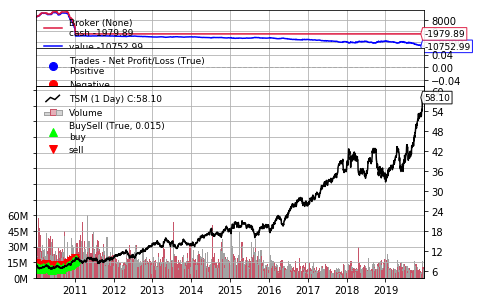

<Figure size 1728x1080 with 0 Axes>

============================================2010-01-04 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         8.19             0.0        8.26       8.11        8.12   

   Position  Total Reward     Volumns  
0   10000.0           0.0  11452747.0  
============================================2010-01-05 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         8.15           -0.05        8.24        8.1         8.2   

   Position  Total Reward     Volumns  
0   9999.95         -0.05  20335395.0  
============================================2010-01-06 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         8.12          -29.95        8.21       8.04        8.17   

   Posi

============================================2010-02-05 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         6.76            0.24        6.86       6.65        6.79   

       Position  Total Reward     Volumns  
0  11023.177143   1023.177143  47714116.0  
============================================2010-02-08 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         6.79           -0.02        6.89       6.67        6.86   

       Position  Total Reward     Volumns  
0  11023.157143   1023.157143  35608415.0  
============================================2010-02-09 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         6.79             0.0        6.94       6.75       

============================================2010-03-11 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.42           -0.76        7.42       7.28        7.32   

       Position  Total Reward     Volumns  
0  11230.565893   1230.565893  26509329.0  
============================================2010-03-12 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0          7.3            0.93        7.42       7.25        7.39   

       Position  Total Reward     Volumns  
0  11231.495893   1231.495893  17864324.0  
============================================2010-03-15 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         7.17      -86.776987        7.25       7.12        7

============================================2010-04-14 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         7.95     -221.657639        7.95       7.65        7.66   

       Position  Total Reward     Volumns  
0  10058.430557     58.430557  43351356.0  
============================================2010-04-15 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         7.87     -469.367639        7.95       7.83        7.91   

      Position  Total Reward     Volumns  
0  9589.062918   -410.937082  12976352.0  
============================================2010-04-16 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         7.67     -329.287639        7.78       7.56        7.77

============================================2010-05-17 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         7.05           -0.14        7.08       6.83        7.02   

   Position  Total Reward     Volumns  
0   9386.76       -613.24  18263933.0  
============================================2010-05-18 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         6.88            0.34        7.12       6.82        7.07   

   Position  Total Reward     Volumns  
0    9387.1        -612.9  22479429.0  
============================================2010-05-19 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         6.94           -0.12        7.01       6.83        6.89   

   Pos

============================================2010-06-18 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         7.21           -0.36        7.32        7.2        7.24   

     Position  Total Reward     Volumns  
0  11104.1875     1104.1875  12565711.0  
============================================2010-06-21 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         7.32            0.66        7.41       7.27        7.31   

     Position  Total Reward     Volumns  
0  11104.8475     1104.8475  21336474.0  
============================================2010-06-22 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.13           -1.14        7.37       7.12        7.31   

============================================2010-07-22 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         7.63             1.2        7.64       7.48        7.48   

       Position  Total Reward     Volumns  
0  13085.980625   3085.980625  18061674.0  
============================================2010-07-23 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         7.68            0.35        7.71       7.57        7.63   

       Position  Total Reward     Volumns  
0  13086.330625   3086.330625  12678809.0  
============================================2010-07-26 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         7.77            0.71        7.77        7.6        7.

============================================2010-08-24 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.01           -0.82         7.1       6.95        7.06   

       Position  Total Reward     Volumns  
0  10512.001846    512.001846  24294498.0  
============================================2010-08-25 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         6.96     -434.350231        7.01       6.85        6.96   

       Position  Total Reward     Volumns  
0  10077.651615     77.651615  16366668.0  
============================================2010-08-26 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         6.93           -0.21        6.98       6.91       

============================================2010-09-27 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         7.27           -0.06        7.33       7.26        7.32   

   Position  Total Reward     Volumns  
0   8770.18      -1229.82  17453887.0  
============================================2010-09-28 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         7.41            0.14        7.42       7.24        7.27   

   Position  Total Reward     Volumns  
0   8770.32      -1229.68  16752714.0  
============================================2010-09-29 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         7.55            0.27        7.61       7.41        7.42   

   Posit

============================================2010-10-28 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0          7.9             0.8        7.99       7.87        7.99   

      Position  Total Reward     Volumns  
0  9090.585455   -909.414545  19208381.0  
============================================2010-10-29 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         8.01            1.22        8.04       7.86        7.89   

      Position  Total Reward     Volumns  
0  9091.805455   -908.194545  17902955.0  
============================================2010-11-01 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0          8.0           -0.11        8.08       7.97        8.01 

============================================2010-12-01 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         8.16      199.983125        8.18       8.01        8.05   

      Position  Total Reward     Volumns  
0  11578.76875    1578.76875  30860540.0  
============================================2010-12-02 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         8.48            3.44        8.51       8.24        8.24   

      Position  Total Reward     Volumns  
0  11582.20875    1582.20875  37959112.0  
============================================2010-12-03 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         8.79            3.68        8.82       8.48        8.52 

============================================2011-01-04 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.28      942.797398        9.28       9.14        9.26   

       Position  Total Reward     Volumns  
0  15047.136425   5047.136425  13217317.0  
============================================2011-01-05 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.08      859.747398        9.22       8.99        9.18   

       Position  Total Reward     Volumns  
0  15906.883824   5906.883824  13309198.0  
============================================2011-01-06 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.45      866.987398        9.49       9.15       

============================================2011-02-07 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        10.04            0.51       10.09       9.98       10.01   

       Position  Total Reward     Volumns  
0  23896.907646  13896.907646  21726123.0  
============================================2011-02-08 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         9.86           -3.13        9.99       9.81        9.93   

       Position  Total Reward     Volumns  
0  23893.777646  13893.777646  16100136.0  
============================================2011-02-09 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         9.62           -4.32        9.86       9.62        

============================================2011-03-11 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         8.97            1.54        9.01       8.84        8.85   

       Position  Total Reward     Volumns  
0  24250.872817  14250.872817  18441599.0  
============================================2011-03-14 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         8.93     -356.334219        8.96       8.83        8.84   

       Position  Total Reward     Volumns  
0  23894.538598  13894.538598  11710157.0  
============================================2011-03-15 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         8.75     -569.054219        8.76       8.53       

============================================2011-04-13 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.01      -33.024205        9.09       8.98        9.07   

       Position  Total Reward     Volumns  
0  22354.333537  12354.333537  15808968.0  
============================================2011-04-14 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         9.04     -153.084205        9.07       8.94        8.95   

       Position  Total Reward     Volumns  
0  22201.249332  12201.249332  16098503.0  
============================================2011-04-15 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         8.97           -1.86        9.04       8.91        9

============================================2011-05-17 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         9.84           -2.09        9.99       9.76        9.89   

       Position  Total Reward     Volumns  
0  25862.164693  15862.164693  28710478.0  
============================================2011-05-18 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         9.94            3.53        10.0        9.9        9.91   

       Position  Total Reward     Volumns  
0  25865.694693  15865.694693  15014010.0  
============================================2011-05-19 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.88           -2.22        9.95       9.81        9

============================================2011-06-20 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         9.48            5.38        9.51       9.36        9.42   

       Position  Total Reward     Volumns  
0  29263.806148  19263.806148  14616393.0  
============================================2011-06-21 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         9.75           10.53        9.76       9.56        9.58   

       Position  Total Reward     Volumns  
0  29274.336148  19274.336148  18227473.0  
============================================2011-06-22 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         9.49          -10.14        9.66       9.48       

============================================2011-07-22 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         9.94           11.52        9.94       9.65        9.65   

       Position  Total Reward     Volumns  
0  29975.669908  19975.669908  21472037.0  
============================================2011-07-25 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         9.76           -6.48        9.81       9.65        9.74   

       Position  Total Reward     Volumns  
0  29969.189908  19969.189908  31896980.0  
============================================2011-07-26 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         9.88            4.32        9.99        9.8       

============================================2011-08-24 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         8.99           -2.35        9.03       8.83        9.03   

      Position  Total Reward     Volumns  
0  26282.05322   16282.05322  18879743.0  
============================================2011-08-25 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         8.69     -385.254506        9.03       8.66        8.95   

       Position  Total Reward     Volumns  
0  25896.798714  15896.798714  23504619.0  
============================================2011-08-26 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.04     -583.854506        9.08       8.73        8

============================================2011-09-27 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1          9.2     -227.188505        9.31       8.99         9.0   

       Position  Total Reward     Volumns  
0  24869.920667  14869.920667  23777356.0  
============================================2011-09-28 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.01     -105.168505        9.19       9.01        9.14   

       Position  Total Reward     Volumns  
0  24764.752162  14764.752162  15135379.0  
============================================2011-09-29 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.04      -87.968505        9.18        8.9       

============================================2011-10-28 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         9.75           -5.12        9.85       9.73        9.83   

      Position  Total Reward     Volumns  
0  23730.94554   13730.94554  17085149.0  
============================================2011-10-31 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         9.66           -2.89        9.76       9.61        9.67   

      Position  Total Reward     Volumns  
0  23728.05554   13728.05554  11655390.0  
============================================2011-11-01 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         9.53           -4.21        9.61       9.36        9.45  

============================================2011-12-01 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        10.11      594.294746       10.16       9.91        9.91   

       Position  Total Reward     Volumns  
0  27825.757607  17825.757607  14681078.0  
============================================2011-12-02 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        10.04            -2.2       10.23      10.02       10.14   

       Position  Total Reward     Volumns  
0  27823.557607  17823.557607  11352871.0  
============================================2011-12-05 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        10.12            2.48       10.18      10.04       10

============================================2012-01-05 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        10.15             3.2       10.17      10.06        10.1   

       Position  Total Reward     Volumns  
0  29880.129515  19880.129515  13461870.0  
============================================2012-01-06 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        10.07           -2.88       10.16      10.02       10.16   

       Position  Total Reward     Volumns  
0  29877.249515  19877.249515  10156781.0  
============================================2012-01-09 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        10.24            6.12       10.25      10.05       

============================================2012-02-08 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        10.86            4.41       10.92      10.73       10.75   

       Position  Total Reward    Volumns  
0  31049.389527  21049.389527  9094576.0  
============================================2012-02-09 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        10.93            3.08       10.96      10.77       10.87   

       Position  Total Reward     Volumns  
0  31052.469527  21052.469527  11887894.0  
============================================2012-02-10 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         10.6          -14.52       10.79      10.56       10

============================================2012-03-13 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        11.38            14.4       11.38      11.14       11.18   

       Position  Total Reward    Volumns  
0  42186.515121  32186.515121  8952591.0  
============================================2012-03-14 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        11.34            -1.6       11.57      11.33       11.43   

       Position  Total Reward    Volumns  
0  42184.915121  32184.915121  8676982.0  
============================================2012-03-15 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        11.44     1549.277122        11.5      11.33       11.4

============================================2012-04-16 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        11.56           -0.12       11.74      11.51       11.68   

       Position  Total Reward    Volumns  
0  57116.839215  47116.839215  8287341.0  
============================================2012-04-17 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        11.64            3.08       11.68      11.49        11.6   

       Position  Total Reward     Volumns  
0  57119.919215  47119.919215  14477443.0  
============================================2012-04-18 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         11.7      1360.74361       11.76      11.47       11.

============================================2012-05-17 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        11.25           -5.27       11.43      11.23       11.35   

       Position  Total Reward     Volumns  
0  70833.416047  60833.416047  14729149.0  
============================================2012-05-18 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        10.93           -9.92       11.35      10.93       11.21   

       Position  Total Reward     Volumns  
0  70823.496047  60823.496047  16553655.0  
============================================2012-05-21 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        11.04            3.41       11.09      10.98       1

============================================2012-06-20 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        10.82            0.64       10.87      10.72       10.77   

      Position  Total Reward    Volumns  
0  71366.70698   61366.70698  7307820.0  
============================================2012-06-21 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         10.4          -13.44       10.75      10.36       10.71   

      Position  Total Reward     Volumns  
0  71353.26698   61353.26698  16767087.0  
============================================2012-06-22 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        10.59            6.08       10.63      10.47        10.5 

============================================2012-07-24 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        10.24             3.5       10.24       10.0       10.04   

       Position  Total Reward     Volumns  
0  73905.898833  63905.898833  23033806.0  
============================================2012-07-25 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        10.32             2.6       10.43      10.19        10.2   

       Position  Total Reward     Volumns  
0  73908.498833  63908.498833  25117960.0  
============================================2012-07-26 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        10.59            8.83       10.65       10.4        10

============================================2012-08-24 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        11.39            0.83       11.45      11.24       11.37   

       Position  Total Reward    Volumns  
0  82684.271625  72684.271625  9720302.0  
============================================2012-08-27 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         11.4            0.22       11.48      11.33       11.46   

       Position  Total Reward    Volumns  
0  82684.491625  72684.491625  8683334.0  
============================================2012-08-28 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        11.35           -1.46       11.42      11.31       11.36 

============================================2012-09-27 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        12.37           14.75       12.38      12.02       12.02   

       Position  Total Reward     Volumns  
0  89392.599723  79392.599723  27847227.0  
============================================2012-09-28 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        12.54            5.27       12.55      12.35       12.37   

       Position  Total Reward     Volumns  
0  89397.869723  79397.869723  23072653.0  
============================================2012-10-01 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        12.61            2.17       12.64      12.45       

============================================2012-11-01 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        12.77            4.57       12.85      12.57       12.68   

        Position  Total Reward    Volumns  
0  100664.086352  90664.086352  9961700.0  
============================================2012-11-02 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         12.5           -8.15       12.82      12.49       12.82   

        Position  Total Reward    Volumns  
0  100655.936352  90655.936352  8799994.0  
============================================2012-11-05 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        12.59     1472.745455        12.6       12.5       1

============================================2012-12-05 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        13.45            5.79       13.57      13.38       13.44   

        Position  Total Reward     Volumns  
0  108470.836657  98470.836657  14938702.0  
============================================2012-12-06 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        13.52            2.45       13.52      13.43       13.46   

        Position  Total Reward    Volumns  
0  108473.286657  98473.286657  9163224.0  
============================================2012-12-07 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         13.5           -0.89       13.75      13.48       

============================================2013-01-09 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        13.91     2008.628974       14.22       13.8       14.08   

        Position   Total Reward     Volumns  
0  118283.470019  108283.470019  16367279.0  
============================================2013-01-10 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        14.41     2067.628974       14.45      14.03       14.12   

        Position   Total Reward     Volumns  
0  120351.098993  110351.098993  19892119.0  
============================================2013-01-11 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        14.39     2267.388974       14.43      14.2

============================================2013-02-12 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        14.67            0.64       14.69      14.54       14.59   

        Position   Total Reward    Volumns  
0  142319.748731  132319.748731  6140095.0  
============================================2013-02-13 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         14.6           -2.11       14.71      14.55       14.68   

        Position   Total Reward    Volumns  
0  142317.638731  132317.638731  8181874.0  
============================================2013-02-14 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        14.72            3.71       14.73      14.57      

============================================2013-03-18 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        13.67          -10.73       13.84      13.64       13.84   

        Position   Total Reward     Volumns  
0  156362.570169  146362.570169  17370827.0  
============================================2013-03-19 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        13.54           -4.53       13.67      13.48       13.65   

        Position   Total Reward     Volumns  
0  156358.040169  146358.040169  15476234.0  
============================================2013-03-20 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        13.68            4.99       13.74      13.56  

============================================2013-04-19 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        14.91     1760.760445       15.05      14.71       14.76   

        Position   Total Reward     Volumns  
0  161222.003546  151222.003546  26635833.0  
============================================2013-04-22 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        14.67     1735.900445       14.88      14.55       14.77   

        Position   Total Reward     Volumns  
0  162957.903991  152957.903991  25698752.0  
============================================2013-04-23 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        14.49     1508.480445       14.68      14.38

============================================2013-05-22 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        14.98          -10.53       15.28      14.93       15.22   

        Position   Total Reward     Volumns  
0  173145.459629  163145.459629  15804021.0  
============================================2013-05-23 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        14.87     1302.090266       14.94      14.59       14.71   

        Position   Total Reward     Volumns  
0  174447.549895  164447.549895  13909802.0  
============================================2013-05-24 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        14.95            3.12       14.96      14.79 

============================================2013-06-25 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         13.9           20.64       13.93      13.59       13.63   

       Position  Total Reward     Volumns  
0  178751.28774  168751.28774  14628318.0  
============================================2013-06-26 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        13.99            3.87       14.04      13.87       13.92   

       Position  Total Reward     Volumns  
0  178755.15774  168755.15774  11587531.0  
============================================2013-06-27 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        14.22      592.098192       14.37      14.13       

============================================2013-07-29 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        13.61       26.243815       13.74      13.59       13.73   

        Position   Total Reward    Volumns  
0  184626.891231  174626.891231  7341855.0  
============================================2013-07-30 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        13.83            8.58       13.96      13.77       13.87   

        Position   Total Reward     Volumns  
0  184635.471231  174635.471231  10552660.0  
============================================2013-07-31 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        13.84      202.803815       13.94      13.83 

============================================2013-08-29 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        13.59     -188.989726       13.65      13.41       13.41   

        Position   Total Reward     Volumns  
0  181831.608497  171831.608497  12224810.0  
============================================2013-08-30 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         13.5           -3.78       13.94      13.46       13.68   

        Position   Total Reward     Volumns  
0  181827.828497  171827.828497  14098312.0  
============================================2013-09-03 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        13.77           11.34       14.04      13.7

============================================2013-10-02 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        14.24             1.5       14.25      14.02       14.18   

        Position   Total Reward    Volumns  
0  187374.075922  177374.075922  9279528.0  
============================================2013-10-03 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        14.43            6.98       14.55      14.28       14.48   

        Position   Total Reward     Volumns  
0  187381.055922  177381.055922  13062358.0  
============================================2013-10-04 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        14.41           -0.69       14.47       14.3    

============================================2013-11-04 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        14.95            -3.9       15.12      14.88       15.08   

        Position   Total Reward    Volumns  
0  194538.490602  184538.490602  9949713.0  
============================================2013-11-05 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        14.74           -8.19       14.81       14.7       14.78   

        Position   Total Reward     Volumns  
0  194530.300602  184530.300602  11491436.0  
============================================2013-11-06 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        14.89      796.974344       14.92      14.69 

============================================2013-12-06 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        14.36      265.009027       14.38      14.26       14.28   

        Position   Total Reward    Volumns  
0  197854.838908  187854.838908  8435723.0  
============================================2013-12-09 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        14.32      406.069027       14.44      14.24       14.43   

        Position   Total Reward     Volumns  
0  198260.907935  188260.907935  11165790.0  
============================================2013-12-10 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        14.16      181.589027       14.25      14.12 

============================================2014-01-10 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        13.77            4.78       13.86      13.71       13.72   

        Position   Total Reward     Volumns  
0  198314.424684  188314.424684  13678557.0  
============================================2014-01-13 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        13.78            0.36       13.97      13.77       13.86   

        Position   Total Reward     Volumns  
0  198314.784684  188314.784684  12621007.0  
============================================2014-01-14 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        14.16            17.1       14.17      13.89 

============================================2014-02-13 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        14.22       62.749177       14.28      14.06       14.06   

       Position  Total Reward    Volumns  
0  200782.89456  190782.89456  8054740.0  
============================================2014-02-14 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        14.58      364.929177       14.64      14.34       14.35   

        Position   Total Reward     Volumns  
0  201147.823738  191147.823738  13828128.0  
============================================2014-02-18 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         14.5           -3.38       14.62      14.41      

============================================2014-03-19 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        15.39     1444.091044       15.57       15.3       15.55   

        Position   Total Reward     Volumns  
0  212493.042405  202493.042405  13002236.0  
============================================2014-03-20 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        15.36           -0.84       15.36      15.05       15.12   

        Position   Total Reward     Volumns  
0  212492.202405  202492.202405  16103344.0  
============================================2014-03-21 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         15.1           -9.83       15.36      15.01  

============================================2014-04-22 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        16.76     2068.567955       16.77      16.59       16.61   

        Position   Total Reward     Volumns  
0  220923.009986  210923.009986  13731562.0  
============================================2014-04-23 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        16.63     2052.977955       16.67      16.54        16.6   

        Position   Total Reward     Volumns  
0  222975.987941  212975.987941  11081862.0  
============================================2014-04-24 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        16.76            5.59       16.79      16.5

============================================2014-05-23 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        16.84     2171.234067       16.89      16.75       16.89   

        Position   Total Reward    Volumns  
0  244352.213601  234352.213601  8809466.0  
============================================2014-05-27 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        17.03            6.89       17.08      16.87       16.98   

        Position   Total Reward    Volumns  
0  244359.103601  234359.103601  9227381.0  
============================================2014-05-28 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         17.0           -1.18       17.13      16.96     

Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        17.13           -0.45       17.24      17.04       17.16   

        Position   Total Reward    Volumns  
0  250655.599448  240655.599448  6352282.0  
============================================2014-06-27 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        17.34      2014.96885       17.36      17.21       17.26   

        Position   Total Reward    Volumns  
0  252670.568298  242670.568298  7136211.0  
============================================2014-06-30 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        17.43      2149.62885       17.48      17.34        17.4   

        Position   Total Reward    Volumns  
0  254820.197148  244820.197148  7964679.0  
===========

============================================2014-07-30 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        17.26            4.93       17.31      17.17       17.28   

        Position   Total Reward     Volumns  
0  279307.416799  269307.416799  11950027.0  
============================================2014-07-31 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        16.66          -20.55        16.9       16.6       16.81   

        Position   Total Reward     Volumns  
0  279286.866799  269286.866799  19600602.0  
============================================2014-08-01 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        16.83            6.09       16.91      16.69  

   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        17.45            1.13       17.46      17.34       17.46   

        Position   Total Reward    Volumns  
0  287100.273531  277100.273531  6388038.0  
============================================2014-09-02 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        17.56            4.34       17.71      17.49       17.51   

        Position   Total Reward    Volumns  
0  287104.613531  277104.613531  9741313.0  
============================================2014-09-03 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        17.79            9.26       17.81      17.64       17.73   

        Position   Total Reward     Volumns  
0  287113.873531  277113.873531  11821494.0  
===================

============================================2014-10-02 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        16.91            6.88       17.01      16.61       16.75   

        Position   Total Reward     Volumns  
0  287076.243531  277076.243531  27527321.0  
============================================2014-10-03 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        17.36           19.35       17.41      17.11       17.17   

        Position   Total Reward     Volumns  
0  287095.593531  277095.593531  23461053.0  
============================================2014-10-06 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        17.35           -0.43       17.42      17.2

============================================2014-11-04 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        18.29            1.76       18.33      18.13       18.32   

        Position   Total Reward     Volumns  
0  293331.924916  283331.924916  10658451.0  
============================================2014-11-05 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        18.36            3.08       18.48       18.2       18.38   

        Position   Total Reward     Volumns  
0  293335.004916  283335.004916  10794546.0  
============================================2014-11-06 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        18.16            -8.8       18.38       18.

   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        18.95     2405.669309        19.0      18.79       18.96   

        Position   Total Reward    Volumns  
0  322615.296932  312615.296932  9216859.0  
============================================2014-12-08 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        18.75     2420.469309       19.08      18.66       18.98   

        Position   Total Reward     Volumns  
0  325035.766241  315035.766241  11286116.0  
============================================2014-12-09 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        18.81            2.28       18.83      18.39       18.56   

        Position   Total Reward     Volumns  
0  325038.046241  315038.046241  11529144.0  
================

============================================2015-01-09 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        17.66     1146.384283       18.03      17.51       18.01   

        Position   Total Reward     Volumns  
0  345066.034386  335066.034386  21117441.0  
============================================2015-01-12 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        17.32      693.014283       17.57      17.24       17.55   

        Position   Total Reward     Volumns  
0  345759.048669  335759.048669  29637502.0  
============================================2015-01-13 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        17.54      671.614283       17.75      17.4

============================================2015-02-12 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        20.39            5.15        20.4      20.12       20.34   

        Position   Total Reward     Volumns  
0  361004.179172  351004.179172  12164730.0  
============================================2015-02-13 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         20.7           11.18        20.8      20.33       20.37   

        Position   Total Reward     Volumns  
0  361015.359172  351015.359172  13966482.0  
============================================2015-02-17 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        20.64      2840.80669       20.74      20.56 

============================================2015-03-18 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        20.59           14.03       20.75      20.12       20.42   

        Position   Total Reward     Volumns  
0  372892.541703  362892.541703  17463895.0  
============================================2015-03-19 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        20.55      2404.53996       20.96      20.52       20.75   

        Position   Total Reward     Volumns  
0  375297.081664  365297.081664  14041132.0  
============================================2015-03-20 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        20.64            3.76       20.75      20.56

============================================2015-04-21 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        19.44      872.335061       19.47       19.3       19.41   

        Position   Total Reward     Volumns  
0  380240.687188  370240.687188  15831360.0  
============================================2015-04-22 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        19.86      978.885061       19.86      19.49        19.5   

        Position   Total Reward     Volumns  
0  381219.572249  371219.572249  19058264.0  
============================================2015-04-23 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        20.25     1336.725061       20.35      19.7

============================================2015-05-22 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        20.16           -1.71       20.48      20.16       20.31   

        Position   Total Reward     Volumns  
0  399712.046244  389712.046244  10290491.0  
============================================2015-05-26 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        20.21            2.07       20.31      20.12       20.14   

        Position   Total Reward     Volumns  
0  399714.116244  389714.116244  13095309.0  
============================================2015-05-27 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         20.5           12.25       20.58      20.08  

============================================2015-06-25 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        20.06            6.93       20.27       20.0       20.03   

        Position   Total Reward     Volumns  
0  403962.496128  393962.496128  10044706.0  
============================================2015-06-26 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        19.69          -17.63       20.03      19.53       19.93   

        Position   Total Reward     Volumns  
0  403944.866128  393944.866128  17768845.0  
============================================2015-06-29 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        19.24           -21.6       19.72      19.22

============================================2015-07-29 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         19.0     -299.759213       19.14      18.69       18.76   

        Position   Total Reward     Volumns  
0  403602.464567  393602.464567  14868561.0  
============================================2015-07-30 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        19.51           23.35       19.58      19.07       19.11   

        Position   Total Reward     Volumns  
0  403625.814567  393625.814567  20244120.0  
============================================2015-07-31 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         19.0      287.140988       19.43      18.94

   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        17.19            2.62       17.26       16.8       16.87   

        Position   Total Reward     Volumns  
0  398433.541083  388433.541083  12775230.0  
============================================2015-08-31 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        17.09           -4.94       17.35      16.98       17.33   

        Position   Total Reward     Volumns  
0  398428.601083  388428.601083  10565436.0  
============================================2015-09-01 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        16.68          -19.68       16.98      16.55       16.63   

        Position   Total Reward     Volumns  
0  398408.921083  388408.921083  16503859.0  
=============

============================================2015-10-01 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        17.93     -584.744163       18.05      17.71       18.01   

        Position   Total Reward     Volumns  
0  388271.794863  378271.794863  16879060.0  
============================================2015-10-02 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        17.84           -3.78       17.85      17.37       17.37   

        Position   Total Reward     Volumns  
0  388268.014863  378268.014863  17766625.0  
============================================2015-10-05 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        18.39            23.1       18.43      17.8

============================================2015-11-03 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        19.57      520.247421       19.73       19.0       19.12   

        Position   Total Reward     Volumns  
0  392119.540249  382119.540249  14945694.0  
============================================2015-11-04 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        20.24     1262.507421       20.34      19.81       19.86   

       Position  Total Reward     Volumns  
0  393382.04767  383382.04767  16720603.0  
============================================2015-11-05 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        19.75          -16.88       19.97      19.73    

============================================2015-12-07 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        19.98           -2.82        20.2      19.92       20.16   

       Position  Total Reward    Volumns  
0  394137.61288  384137.61288  5391266.0  
============================================2015-12-08 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        19.84           -6.23       19.96      19.67       19.77   

       Position  Total Reward    Volumns  
0  394131.38288  384131.38288  7136272.0  
============================================2015-12-09 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        19.54          -13.99       19.78      19.47       19.73 

============================================2016-01-11 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        17.99             3.9       18.27      17.79        18.2   

        Position   Total Reward     Volumns  
0  400616.610646  390616.610646  11367961.0  
============================================2016-01-12 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        17.84           -5.85       18.26      17.63       18.25   

        Position   Total Reward     Volumns  
0  400610.760646  390610.760646  13529819.0  
============================================2016-01-13 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         17.6           -9.36       18.11      17.5

============================================2016-02-12 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        19.12            8.15       19.18      18.84       19.16   

        Position   Total Reward    Volumns  
0  395339.399446  385339.399446  8524226.0  
============================================2016-02-16 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        20.06           38.22       20.36      19.42       19.44   

        Position   Total Reward     Volumns  
0  395377.619446  385377.619446  16106087.0  
============================================2016-02-17 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        20.32     1064.848306       20.41       20.0  

============================================2016-03-17 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        22.15           -0.33       22.22      22.02       22.12   

        Position   Total Reward    Volumns  
0  411984.151804  401984.151804  7288447.0  
============================================2016-03-18 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        22.38            8.51       22.56      22.18       22.24   

        Position   Total Reward    Volumns  
0  411992.661804  401992.661804  8386711.0  
============================================2016-03-21 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        22.29           -3.28       22.37      22.13    

============================================2016-04-20 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        21.59           -1.24        21.7      21.26       21.43   

        Position   Total Reward     Volumns  
0  433316.629864  423316.629864  10925980.0  
============================================2016-04-21 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        21.63            1.24       21.79      21.49       21.75   

        Position   Total Reward    Volumns  
0  433317.869864  423317.869864  7032146.0  
============================================2016-04-22 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        21.55           -2.48       21.75      21.45 

============================================2016-05-23 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        20.86     1441.599268       21.28      20.81       21.17   

        Position   Total Reward    Volumns  
0  436296.940483  426296.940483  7957758.0  
============================================2016-05-24 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        21.03     1167.199268       21.12      20.85        20.9   

        Position   Total Reward    Volumns  
0  437464.139752  427464.139752  8811240.0  
============================================2016-05-25 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        21.16     1415.819268       21.25      21.08   

============================================2016-06-24 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        22.07     2094.028651       22.52      21.93        22.0   

        Position   Total Reward     Volumns  
0  471890.336193  461890.336193  11087113.0  
============================================2016-06-27 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        22.22     2088.288651       22.27      21.73       21.98   

        Position   Total Reward     Volumns  
0  473978.624844  463978.624844  11560831.0  
============================================2016-06-28 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        22.54            3.56       22.63      22.38 

============================================2016-07-28 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        25.11            0.32       25.33      24.98       25.24   

        Position   Total Reward    Volumns  
0  507547.830852  497547.830852  5319912.0  
============================================2016-07-29 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        24.78           -2.64       25.07      24.68       25.07   

        Position   Total Reward    Volumns  
0  507545.190852  497545.190852  8256887.0  
============================================2016-08-01 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        25.53             6.0       25.65      25.29   

============================================2016-08-30 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        25.53     1283.263842        25.6      25.45       25.51   

        Position   Total Reward    Volumns  
0  529919.248475  519919.248475  5606290.0  
============================================2016-08-31 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        25.64            0.33       25.86      25.58       25.66   

        Position   Total Reward    Volumns  
0  529919.578475  519919.578475  5239659.0  
============================================2016-09-01 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        25.84            0.84        25.9      25.54     

============================================2016-10-03 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        27.41            1.32       27.49      27.27       27.34   

        Position   Total Reward    Volumns  
0  533676.925559  523676.925559  4705908.0  
============================================2016-10-04 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        27.11     1264.552222       27.59      27.09        27.5   

        Position   Total Reward    Volumns  
0  534941.477781  524941.477781  5721738.0  
============================================2016-10-05 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        27.24             1.3        27.4      27.21   

============================================2016-11-03 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        27.02           -0.54       27.21      26.93       27.08   

        Position   Total Reward    Volumns  
0  544213.943334  534213.943334  5481875.0  
============================================2016-11-04 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        26.98      -47.523889       27.17      26.78       26.95   

        Position   Total Reward    Volumns  
0  544166.419445  534166.419445  4967515.0  
============================================2016-11-07 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        27.97      416.676111        28.0      27.37   

   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        26.33            2.82       26.42      26.05       26.15   

        Position   Total Reward    Volumns  
0  547083.315208  537083.315208  4860249.0  
============================================2016-12-07 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         26.7            2.59       26.71       26.1        26.3   

        Position   Total Reward    Volumns  
0  547085.905208  537085.905208  4384334.0  
============================================2016-12-08 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         26.8             0.7       27.01      26.64       27.01   

        Position   Total Reward    Volumns  
0  547086.605208  537086.605208  4589451.0  
===================

   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        26.83            0.48       27.03      26.68        26.8   

        Position   Total Reward    Volumns  
0  548566.096275  538566.096275  8498319.0  
============================================2017-01-11 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        26.92            1.44       26.94      26.52       26.57   

        Position   Total Reward    Volumns  
0  548567.536275  538567.536275  8369757.0  
============================================2017-01-12 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        26.13          -12.64       26.64      25.86       26.16   

        Position   Total Reward     Volumns  
0  548554.896275  538554.896275  14607200.0  
=================

============================================2017-02-13 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        28.27           14.59       28.37       27.6        27.6   

        Position   Total Reward     Volumns  
0  559215.345684  549215.345684  11436975.0  
============================================2017-02-14 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        27.95           -5.57       28.08      27.76       28.08   

        Position   Total Reward    Volumns  
0  559209.775684  549209.775684  5838082.0  
============================================2017-02-15 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        28.33            6.84       28.37       28.1   

============================================2017-03-17 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        29.08     2045.548266       29.23      28.94       29.08   

        Position   Total Reward    Volumns  
0  569455.176002  559455.176002  6949074.0  
============================================2017-03-20 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        29.31     2226.208266       29.54      29.18       29.26   

        Position   Total Reward    Volumns  
0  571681.384269  561681.384269  5746285.0  
============================================2017-03-21 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        28.98     2618.468266       29.91      28.94    

============================================2017-04-20 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        28.36      350.548815       28.43      28.23       28.34   

        Position   Total Reward    Volumns  
0  584908.374225  574908.374225  4749845.0  
============================================2017-04-21 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        28.62      641.328815       28.67      28.51       28.63   

       Position  Total Reward    Volumns  
0  585549.70304  575549.70304  5077919.0  
============================================2017-04-24 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        29.17     1083.708815       29.26      28.99       

============================================2017-05-23 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        31.58     2416.202163       31.66      31.49       31.57   

        Position   Total Reward    Volumns  
0  609908.989183  599908.989183  7411987.0  
============================================2017-05-24 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        31.69            0.64       31.75      31.53        31.6   

        Position   Total Reward    Volumns  
0  609909.629183  599909.629183  8756676.0  
============================================2017-05-25 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        31.73     2258.595136       31.93      31.66    

============================================2017-06-26 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        33.28        -1240.58       33.64      33.09       33.57   

   Position  Total Reward     Volumns  
0  622698.1      612698.1  10992840.0  
============================================2017-06-27 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        32.33          -638.1       32.97      32.22       32.97   

   Position  Total Reward    Volumns  
0  622060.0      612060.0  8771845.0  
============================================2017-06-28 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        32.57          -160.0        32.6      32.01       32.49   

   Position

============================================2017-07-28 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        33.04             2.9       33.23      32.89       33.21   

     Position  Total Reward    Volumns  
0  621657.744    611657.744  3992817.0  
============================================2017-07-31 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        33.13            -0.9       33.53      33.03       33.19   

     Position  Total Reward    Volumns  
0  621656.844    611656.844  8420694.0  
============================================2017-08-01 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        33.02         95.3056       33.16       32.9       33.12   

   

============================================2017-08-30 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        34.02           -0.44       34.16       33.9       33.98   

      Position  Total Reward    Volumns  
0  621928.3551   611928.3551  3081559.0  
============================================2017-08-31 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        34.06           -0.46       34.07      33.81       34.04   

      Position  Total Reward    Volumns  
0  621927.8951   611927.8951  4655175.0  
============================================2017-09-01 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        34.29           -2.96       34.31       34.0       34.09   

============================================2017-10-03 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        35.41           -6.79       35.44      35.24       35.34   

        Position   Total Reward    Volumns  
0  619300.248446  609300.248446  4045680.0  
============================================2017-10-04 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        35.26            3.75       35.32      35.13       35.24   

        Position   Total Reward    Volumns  
0  619303.998446  609303.998446  2949457.0  
============================================2017-10-05 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        35.43    -1425.439938       35.79      35.37    

============================================2017-11-03 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        38.87    -3856.185148        38.9      38.31        38.6   

        Position   Total Reward    Volumns  
0  578388.082365  568388.082365  6665804.0  
============================================2017-11-06 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        39.09           -3.74       39.13      38.77       38.87   

        Position   Total Reward    Volumns  
0  578384.342365  568384.342365  6133485.0  
============================================2017-11-07 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        39.16           -1.07       39.35      38.93    

============================================2017-12-07 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        35.94           -5.27       35.96      35.57        35.7   

        Position   Total Reward     Volumns  
0  563567.490404  553567.490404  12250039.0  
============================================2017-12-08 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        35.93            0.52       36.44      35.88       36.28   

        Position   Total Reward    Volumns  
0  563568.010404  553568.010404  5505103.0  
============================================2017-12-11 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        36.27           -6.12       36.46      36.09 

============================================2018-01-11 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         37.8            5.67       38.14      37.73       37.97   

        Position   Total Reward    Volumns  
0  557262.095424  547262.095424  6189170.0  
============================================2018-01-12 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        37.95           -3.59       38.05      37.55       37.81   

        Position   Total Reward    Volumns  
0  557258.505424  547258.505424  5457776.0  
============================================2018-01-16 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         38.9           -23.0       39.02      38.52   

============================================2018-02-14 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        39.66    -1189.108811        39.7      38.62       38.85   

       Position  Total Reward    Volumns  
0  534354.72028  524354.72028  7446478.0  
============================================2018-02-15 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        40.09          -10.75        40.3      39.38       40.09   

       Position  Total Reward    Volumns  
0  534343.97028  524343.97028  6639318.0  
============================================2018-02-16 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        40.06            0.75        40.5       39.9       39.9

============================================2018-03-20 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         41.3            -6.0       41.37      41.01       41.18   

        Position   Total Reward    Volumns  
0  519006.718833  509006.718833  6951610.0  
============================================2018-03-21 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        41.18            3.36       41.32      40.77       41.06   

        Position   Total Reward    Volumns  
0  519010.078833  509010.078833  7637848.0  
============================================2018-03-22 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        40.25           28.28       40.88      40.25    

============================================2018-04-23 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         35.7            6.49        36.0       35.5       35.89   

        Position   Total Reward     Volumns  
0  512930.650635  502930.650635  12133783.0  
============================================2018-04-24 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         35.7            0.27       36.12      35.28       35.97   

        Position   Total Reward     Volumns  
0  512930.920635  502930.920635  14115538.0  
============================================2018-04-25 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        35.16           19.98       35.46      35.0

============================================2018-05-24 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        36.18     2559.207535       36.34      35.73       36.27   

        Position   Total Reward    Volumns  
0  533501.766415  523501.766415  8608699.0  
============================================2018-05-25 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        36.21     2797.107535       36.38      35.86       36.02   

       Position  Total Reward    Volumns  
0  536298.87395  526298.87395  5864830.0  
============================================2018-05-29 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        35.16     3388.487535       35.52      35.04       35

============================================2018-06-27 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        33.91     3577.846416       34.68      33.91       34.62   

        Position   Total Reward    Volumns  
0  567026.106779  557026.106779  9213084.0  
============================================2018-06-28 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        34.32          -11.49       34.32      33.76        33.9   

        Position   Total Reward    Volumns  
0  567014.616779  557014.616779  7538558.0  
============================================2018-06-29 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        34.91          -16.52       35.11       34.8   

============================================2018-07-31 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        39.35           -4.18       39.71      39.24        39.4   

        Position   Total Reward    Volumns  
0  565524.583439  555524.583439  5139812.0  
============================================2018-08-01 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        39.83           -18.5       39.85      39.46       39.57   

        Position   Total Reward    Volumns  
0  565506.083439  555506.083439  6403429.0  
============================================2018-08-02 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        39.68    -1595.994447       39.77      39.15     

============================================2018-08-31 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        41.64           -5.08       41.65      41.02       41.18   

        Position   Total Reward    Volumns  
0  548013.708108  538013.708108  9197167.0  
============================================2018-09-04 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        42.12          -16.32       42.13      41.24       41.31   

        Position   Total Reward    Volumns  
0  547997.388108  537997.388108  8560489.0  
============================================2018-09-05 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        42.23           -3.74       42.56      42.04   

============================================2018-10-04 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        40.52           44.41       41.14      40.08       41.13   

        Position   Total Reward    Volumns  
0  517045.337989  507045.337989  8256916.0  
============================================2018-10-05 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        39.75    -1261.910903       40.18      39.32       39.99   

        Position   Total Reward    Volumns  
0  515783.427086  505783.427086  8295032.0  
============================================2018-10-08 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        39.12     -197.510903       39.32      38.58     

============================================2018-11-06 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        36.99            -6.0        37.1      36.69       36.77   

        Position   Total Reward    Volumns  
0  526659.631202  516659.631202  8982707.0  
============================================2018-11-07 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        37.42          -10.75       37.53      36.98       37.52   

        Position   Total Reward    Volumns  
0  526648.881202  516648.881202  6878529.0  
============================================2018-11-08 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        36.96           11.58        37.3      36.95   

============================================2018-12-11 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        35.05           -8.33       35.67      34.66       35.56   

        Position   Total Reward    Volumns  
0  535914.224346  525914.224346  9043128.0  
============================================2018-12-12 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         35.7          -22.75        36.0      35.59       35.92   

        Position   Total Reward    Volumns  
0  535891.474346  525891.474346  8801861.0  
============================================2018-12-13 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        35.65            1.75       35.96      35.51   

============================================2019-01-15 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        34.42     2548.711599        34.6      34.19       34.42   

        Position   Total Reward     Volumns  
0  564062.505644  554062.505644  10645295.0  
============================================2019-01-16 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        34.03           13.26       34.41      34.03       34.28   

        Position   Total Reward    Volumns  
0  564075.765644  554075.765644  9139049.0  
============================================2019-01-17 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        34.66          -22.73        34.9      33.26 

============================================2019-02-19 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        36.73          -14.63       36.92      36.38        36.5   

        Position   Total Reward    Volumns  
0  563974.165644  553974.165644  8488025.0  
============================================2019-02-20 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        37.24          -20.97       37.73      37.14       37.18   

        Position   Total Reward    Volumns  
0  563953.195644  553953.195644  7517196.0  
============================================2019-02-21 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        37.22            0.93       37.42      37.05   

============================================2019-03-22 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        38.61           25.52       39.17      38.52        39.0   

        Position   Total Reward    Volumns  
0  558297.862558  548297.862558  7077910.0  
============================================2019-03-25 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        38.12           21.64       38.64      37.98        38.2   

        Position   Total Reward    Volumns  
0  558319.502558  548319.502558  5133005.0  
============================================2019-03-26 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        38.58           -20.7        38.8      38.27   

============================================2019-04-25 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        42.48           37.39       43.01      42.43       42.91   

        Position   Total Reward     Volumns  
0  519979.122936  509979.122936  10628541.0  
============================================2019-04-26 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        41.96           22.36       42.02      41.37       41.68   

        Position   Total Reward     Volumns  
0  520001.482936  510001.482936  13346149.0  
============================================2019-04-29 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        41.86    -4450.950766       41.94      41.62

============================================2019-05-29 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        35.99           -2.06       36.05      35.51       35.77   

        Position   Total Reward     Volumns  
0  512675.727869  502675.727869  13658205.0  
============================================2019-05-30 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        36.33          -16.07       36.64      36.14       36.24   

        Position   Total Reward    Volumns  
0  512659.657869  502659.657869  7698356.0  
============================================2019-05-31 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        36.62          -13.92       37.21      36.53  

============================================2019-07-01 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         40.8           -87.2       41.31      40.57       40.96   

        Position   Total Reward     Volumns  
0  512056.422222  502056.422222  11242718.0  
============================================2019-07-02 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        40.23            22.8       40.73      40.17       40.61   

        Position   Total Reward    Volumns  
0  512079.222222  502079.222222  4508690.0  
============================================2019-07-03 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        39.77           18.42       39.81      39.45 

============================================2019-08-02 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        41.07            7.69        41.2      40.44       40.57   

       Position  Total Reward    Volumns  
0  489085.77684  479085.77684  9449221.0  
============================================2019-08-05 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        39.31           70.93       39.95      39.22       39.84   

       Position  Total Reward    Volumns  
0  489156.70684  479156.70684  6763034.0  
============================================2019-08-06 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        40.68          -56.25       40.93      40.32        40.6

============================================2019-09-05 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        43.62          -38.52       43.89      43.15       43.15   

        Position   Total Reward    Volumns  
0  463187.672276  453187.672276  7807551.0  
============================================2019-09-06 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         43.1           18.72       43.42      43.08       43.38   

        Position   Total Reward    Volumns  
0  463206.392276  453206.392276  4386682.0  
============================================2019-09-09 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        43.24           -5.04       43.46      42.93   

============================================2019-10-08 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        47.53            3.73       48.06      47.27       47.93   

        Position   Total Reward     Volumns  
0  433517.752696  423517.752696  13181143.0  
============================================2019-10-09 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        48.34          -31.25       48.72      47.84       47.87   

        Position   Total Reward     Volumns  
0  433486.502696  423486.502696  11110175.0  
============================================2019-10-10 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        48.59           -9.77       49.05      48.1

============================================2019-11-08 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        52.46            37.8       53.16      52.17       53.16   

        Position   Total Reward    Volumns  
0  416140.360478  406140.360478  6604216.0  
============================================2019-11-11 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        52.24            9.69       52.38       51.8       52.03   

        Position   Total Reward    Volumns  
0  416150.050478  406150.050478  4074768.0  
============================================2019-11-12 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        51.79           21.23       52.32      51.67   

============================================2019-12-12 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         58.2         -154.68       58.21      56.62       56.85   

        Position   Total Reward     Volumns  
0  406514.135196  396514.135196  15898998.0  
============================================2019-12-13 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        57.85           21.09       59.11      57.85       58.64   

        Position   Total Reward    Volumns  
0  406535.225196  396535.225196  9955968.0  
============================================2019-12-16 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        58.13          -16.76       58.29      57.89 

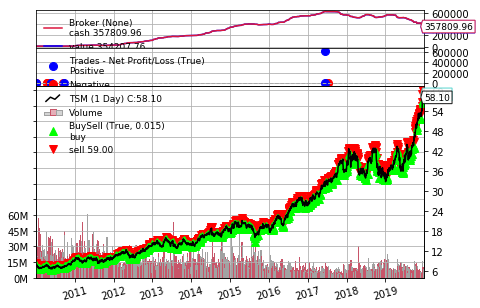

<Figure size 1728x1080 with 0 Axes>

============================================2010-01-04 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         8.19             0.0        8.26       8.11        8.12   

   Position  Total Reward     Volumns  
0   10000.0           0.0  11452747.0  
============================================2010-01-05 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         8.15             0.0        8.24        8.1         8.2   

   Position  Total Reward     Volumns  
0   10000.0           0.0  20335395.0  
============================================2010-01-06 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         8.12            0.05        8.21       8.04        8.17   

   Posi

============================================2010-02-05 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         6.76            0.27        6.86       6.65        6.79   

   Position  Total Reward     Volumns  
0   9971.02        -28.98  47714116.0  
============================================2010-02-08 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         6.79           -0.12        6.89       6.67        6.86   

   Position  Total Reward     Volumns  
0    9970.9         -29.1  35608415.0  
============================================2010-02-09 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         6.79             0.0        6.94       6.75        6.86   

   Pos

============================================2010-03-11 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.42           -0.87        7.42       7.28        7.32   

   Position  Total Reward     Volumns  
0  9689.198      -310.802  26509329.0  
============================================2010-03-12 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1          7.3            1.05        7.42       7.25        7.39   

   Position  Total Reward     Volumns  
0  9690.248      -309.752  17864324.0  
============================================2010-03-15 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.17            1.24        7.25       7.12        7.24   

   Pos

============================================2010-04-14 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         7.95     -405.823643        7.95       7.65        7.66   

      Position  Total Reward     Volumns  
0  8429.940071  -1570.059929  43351356.0  
============================================2010-04-15 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.87     -650.103643        7.95       7.83        7.91   

      Position  Total Reward     Volumns  
0  7779.836429  -2220.163571  12976352.0  
============================================2010-04-16 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         7.67             2.1        7.78       7.56        7.77 

============================================2010-05-17 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.05           -0.94        7.08       6.83        7.02   

      Position  Total Reward     Volumns  
0  5481.180982  -4518.819018  18263933.0  
============================================2010-05-18 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         6.88            2.57        7.12       6.82        7.07   

      Position  Total Reward     Volumns  
0  5483.750982  -4516.249018  22479429.0  
============================================2010-05-19 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         6.94            -0.9        7.01       6.83        6.89

============================================2010-06-18 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.21      -86.156965        7.32        7.2        7.24   

      Position  Total Reward     Volumns  
0  8563.243576  -1436.756424  12565711.0  
============================================2010-06-21 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.32           -1.33        7.41       7.27        7.31   

      Position  Total Reward     Volumns  
0  8561.913576  -1438.086424  21336474.0  
============================================2010-06-22 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         7.13            2.65        7.37       7.12        7.3

============================================2010-07-22 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.63     -233.286315        7.64       7.48        7.48   

      Position  Total Reward     Volumns  
0  8251.908411  -1748.091589  18061674.0  
============================================2010-07-23 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.68           -0.75        7.71       7.57        7.63   

      Position  Total Reward     Volumns  
0  8251.158411  -1748.841589  12678809.0  
============================================2010-07-26 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.77           -1.43        7.77        7.6        7.6

============================================2010-08-24 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.01      267.860956         7.1       6.95        7.06   

      Position  Total Reward     Volumns  
0  8670.914193  -1329.085807  24294498.0  
============================================2010-08-25 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         6.96            1.35        7.01       6.85        6.96   

      Position  Total Reward     Volumns  
0  8672.264193  -1327.735807  16366668.0  
============================================2010-08-26 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         6.93       362.51485        6.98       6.91        6.95 

============================================2010-09-27 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         7.27            2.33        7.33       7.26        7.32   

      Position  Total Reward     Volumns  
0  9403.128459   -596.871541  17453887.0  
============================================2010-09-28 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         7.41           -5.46        7.42       7.24        7.27   

      Position  Total Reward     Volumns  
0  9397.668459   -602.331541  16752714.0  
============================================2010-09-29 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         7.55           -5.46        7.61       7.41        7.4

============================================2010-10-28 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1          7.9     -635.125487        7.99       7.87        7.99   

      Position  Total Reward     Volumns  
0  8475.148864  -1524.851136  19208381.0  
============================================2010-10-29 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         8.01           -5.51        8.04       7.86        7.89   

      Position  Total Reward     Volumns  
0  8469.638864  -1530.361136  17902955.0  
============================================2010-11-01 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2          8.0             0.5        8.08       7.97        8.0

============================================2010-12-01 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         8.16           -14.3        8.18       8.01        8.05   

      Position  Total Reward     Volumns  
0  7352.293167  -2647.706833  30860540.0  
============================================2010-12-02 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         8.48          -17.84        8.51       8.24        8.24   

      Position  Total Reward     Volumns  
0  7334.453167  -2665.546833  37959112.0  
============================================2010-12-03 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         8.79          -17.63        8.82       8.48        8.5

============================================2011-01-04 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         9.28           -1.56        9.28       9.14        9.26   

     Position  Total Reward     Volumns  
0 -900.670743 -10900.670743  13217317.0  
============================================2011-01-05 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         9.08            10.4        9.22       8.99        9.18   

     Position  Total Reward     Volumns  
0 -890.270743 -10890.270743  13309198.0  
============================================2011-01-06 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         9.45          -19.24        9.49       9.15        9.18   

 

============================================2011-02-07 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        10.04           -1.56       10.09       9.98       10.01   

     Position  Total Reward     Volumns  
0 -940.190743 -10940.190743  21726123.0  
============================================2011-02-08 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         9.86            9.36        9.99       9.81        9.93   

     Position  Total Reward     Volumns  
0 -930.830743 -10930.830743  16100136.0  
============================================2011-02-09 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         9.62           12.48        9.86       9.62        9.74   



============================================2011-03-11 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         8.97           -3.64        9.01       8.84        8.85   

     Position  Total Reward     Volumns  
0 -884.550743 -10884.550743  18441599.0  
============================================2011-03-14 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         8.93            2.08        8.96       8.83        8.84   

     Position  Total Reward     Volumns  
0 -882.470743 -10882.470743  11710157.0  
============================================2011-03-15 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         8.75            9.36        8.76       8.53        8.63   



   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.01           -1.56        9.09       8.98        9.07   

     Position  Total Reward     Volumns  
0 -886.630743 -10886.630743  15808968.0  
============================================2011-04-14 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.04           -1.56        9.07       8.94        8.95   

     Position  Total Reward     Volumns  
0 -888.190743 -10888.190743  16098503.0  
============================================2011-04-15 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         8.97            3.64        9.04       8.91        9.01   

     Position  Total Reward    Volumns  
0 -884.550743 -10884.550743  8611851.0  
=======================================

============================================2011-05-17 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.84            3.12        9.99       9.76        9.89   

     Position  Total Reward     Volumns  
0 -929.790743 -10929.790743  28710478.0  
============================================2011-05-18 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.94            -5.2        10.0        9.9        9.91   

     Position  Total Reward     Volumns  
0 -934.990743 -10934.990743  15014010.0  
============================================2011-05-19 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.88            3.12        9.95       9.81        9.94   

============================================2011-06-20 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.48           -7.28        9.51       9.36        9.42   

     Position  Total Reward     Volumns  
0 -911.070743 -10911.070743  14616393.0  
============================================2011-06-21 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.75          -14.04        9.76       9.56        9.58   

     Position  Total Reward     Volumns  
0 -925.110743 -10925.110743  18227473.0  
============================================2011-06-22 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.49           13.52        9.66       9.48        9.66   

============================================2011-07-22 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.94          -16.64        9.94       9.65        9.65   

     Position  Total Reward     Volumns  
0 -934.990743 -10934.990743  21472037.0  
============================================2011-07-25 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.76            9.36        9.81       9.65        9.74   

     Position  Total Reward     Volumns  
0 -925.630743 -10925.630743  31896980.0  
============================================2011-07-26 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.88           -6.24        9.99        9.8        9.81   

============================================2011-08-24 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         8.99            3.64        9.03       8.83        9.03   

     Position  Total Reward     Volumns  
0 -885.590743 -10885.590743  18879743.0  
============================================2011-08-25 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         8.69            15.6        9.03       8.66        8.95   

     Position  Total Reward     Volumns  
0 -869.990743 -10869.990743  23504619.0  
============================================2011-08-26 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.04           -18.2        9.08       8.73        8.73   


============================================2011-09-27 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0          9.2           -18.2        9.31       8.99         9.0   

     Position  Total Reward     Volumns  
0 -896.510743 -10896.510743  23777356.0  
============================================2011-09-28 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.01            9.88        9.19       9.01        9.14   

     Position  Total Reward     Volumns  
0 -886.630743 -10886.630743  15135379.0  
============================================2011-09-29 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         9.04           -1.56        9.18        8.9        9.15   


============================================2011-10-31 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         9.66            4.68        9.76       9.61        9.67   

     Position  Total Reward     Volumns  
0 -920.430743 -10920.430743  11655390.0  
============================================2011-11-01 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         9.53            6.76        9.61       9.36        9.45   

     Position  Total Reward     Volumns  
0 -913.670743 -10913.670743  19289239.0  
============================================2011-11-02 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         9.74          -10.92        9.75       9.58        9.64   



============================================2011-12-02 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        10.04            3.64       10.23      10.02       10.14   

     Position  Total Reward     Volumns  
0 -940.190743 -10940.190743  11352871.0  
============================================2011-12-05 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        10.12           -4.16       10.18      10.04       10.16   

     Position  Total Reward     Volumns  
0 -944.350743 -10944.350743  20709862.0  
============================================2011-12-06 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         9.91           10.92       10.05       9.89        9.99   


============================================2012-01-06 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        10.07            4.16       10.16      10.02       10.16   

     Position  Total Reward     Volumns  
0 -941.750743 -10941.750743  10156781.0  
============================================2012-01-09 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        10.24           -8.84       10.25      10.05       10.07   

     Position  Total Reward    Volumns  
0 -950.590743 -10950.590743  9852827.0  
============================================2012-01-10 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        10.54           -15.6       10.58       10.3       10.36   



============================================2012-02-09 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        10.93           -3.64       10.96      10.77       10.87   

     Position  Total Reward     Volumns  
0 -986.470743 -10986.470743  11887894.0  
============================================2012-02-10 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         10.6           17.16       10.79      10.56       10.78   

     Position  Total Reward     Volumns  
0 -969.310743 -10969.310743  11711033.0  
============================================2012-02-13 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         10.8           -10.4       10.84      10.71       10.79   


============================================2012-03-14 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        11.34            2.08       11.57      11.33       11.43   

      Position  Total Reward    Volumns  
0 -1007.790743 -11007.790743  8676982.0  
============================================2012-03-15 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        11.44            -5.2        11.5      11.33       11.43   

      Position  Total Reward    Volumns  
0 -1012.990743 -11012.990743  9207694.0  
============================================2012-03-16 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        11.32            6.24       11.43       11.3        11.4   

============================================2012-04-17 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        11.64           -4.16       11.68      11.49        11.6   

      Position  Total Reward     Volumns  
0 -1023.390743 -11023.390743  14477443.0  
============================================2012-04-18 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         11.7           -3.12       11.76      11.47       11.61   

      Position  Total Reward    Volumns  
0 -1026.510743 -11026.510743  7874190.0  
============================================2012-04-19 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        11.68            1.04       11.83      11.59       11.75  

============================================2012-05-18 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        10.93           16.64       11.35      10.93       11.21   

     Position  Total Reward     Volumns  
0 -986.470743 -10986.470743  16553655.0  
============================================2012-05-21 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        11.04           -5.72       11.09      10.98       11.01   

     Position  Total Reward     Volumns  
0 -992.190743 -10992.190743  23845408.0  
============================================2012-05-22 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        11.02            1.04       11.12      10.96       11.02   



============================================2012-06-21 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         10.4           21.84       10.75      10.36       10.71   

     Position  Total Reward     Volumns  
0 -958.910743 -10958.910743  16767087.0  
============================================2012-06-22 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        10.59           -9.88       10.63      10.47        10.5   

     Position  Total Reward     Volumns  
0 -968.790743 -10968.790743  10599584.0  
============================================2012-06-25 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        10.24            18.2       10.48      10.22       10.43   

============================================2012-07-25 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        10.32           -4.16       10.43      10.19        10.2   

     Position  Total Reward     Volumns  
0 -954.750743 -10954.750743  25117960.0  
============================================2012-07-26 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        10.59          -14.04       10.65       10.4        10.4   

     Position  Total Reward     Volumns  
0 -968.790743 -10968.790743  24796482.0  
============================================2012-07-27 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        10.85          -13.52       10.91      10.68        10.7   


============================================2012-08-27 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         11.4           -0.52       11.48      11.33       11.46   

      Position  Total Reward    Volumns  
0 -1010.910743 -11010.910743  8683334.0  
============================================2012-08-28 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        11.35             2.6       11.42      11.31       11.36   

      Position  Total Reward    Volumns  
0 -1008.310743 -11008.310743  7233062.0  
============================================2012-08-29 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        11.38           -1.56       11.43      11.29       11.33   

============================================2012-09-28 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        12.54           -8.84       12.55      12.35       12.37   

      Position  Total Reward     Volumns  
0 -1070.190743 -11070.190743  23072653.0  
============================================2012-10-01 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        12.61           -3.64       12.64      12.45       12.47   

      Position  Total Reward     Volumns  
0 -1073.830743 -11073.830743  24481807.0  
============================================2012-10-02 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        12.69           -4.16       12.73      12.58       12.67

============================================2012-11-02 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         12.5           14.04       12.82      12.49       12.82   

      Position  Total Reward    Volumns  
0 -1068.110743 -11068.110743  8799994.0  
============================================2012-11-05 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        12.59           -4.68        12.6       12.5       12.56   

      Position  Total Reward     Volumns  
0 -1072.790743 -11072.790743  16504751.0  
============================================2012-11-06 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        12.84           -13.0       12.91      12.59        12.6  

============================================2012-12-06 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        13.52           -3.64       13.52      13.43       13.46   

      Position  Total Reward    Volumns  
0 -1121.150743 -11121.150743  9163224.0  
============================================2012-12-07 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         13.5            1.04       13.75      13.48       13.69   

      Position  Total Reward     Volumns  
0 -1120.110743 -11120.110743  16198655.0  
============================================2012-12-10 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        13.38            6.24       13.54      13.35       13.45  

============================================2013-01-10 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        14.41           -26.0       14.45      14.03       14.12   

      Position  Total Reward     Volumns  
0 -1167.430743 -11167.430743  19892119.0  
============================================2013-01-11 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        14.39            1.04       14.43      14.21       14.34   

      Position  Total Reward     Volumns  
0 -1166.390743 -11166.390743  15836559.0  
============================================2013-01-14 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        14.28            5.72       14.43      14.19        14.4  

============================================2013-02-13 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         14.6            3.64       14.71      14.55       14.68   

      Position  Total Reward    Volumns  
0 -1177.310743 -11177.310743  8181874.0  
============================================2013-02-14 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        14.72           -6.24       14.73      14.57       14.61   

      Position  Total Reward    Volumns  
0 -1183.550743 -11183.550743  6416932.0  
============================================2013-02-15 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        14.69            1.56       14.75      14.66       14.71   

============================================2013-03-19 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        13.54            6.76       13.67      13.48       13.65   

      Position  Total Reward     Volumns  
0 -1122.190743 -11122.190743  15476234.0  
============================================2013-03-20 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        13.68           -7.28       13.74      13.56       13.59   

      Position  Total Reward     Volumns  
0 -1129.470743 -11129.470743  13772457.0  
============================================2013-03-21 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        13.39           15.08       13.57      13.38       13.57 

============================================2013-04-22 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        14.67           12.48       14.88      14.55       14.77   

      Position  Total Reward     Volumns  
0 -1180.950743 -11180.950743  25698752.0  
============================================2013-04-23 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        14.49            9.36       14.68      14.38       14.54   

      Position  Total Reward     Volumns  
0 -1171.590743 -11171.590743  27321680.0  
============================================2013-04-24 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        14.62           -6.76       14.69      14.44       14.46  

============================================2013-05-23 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        14.87            5.72       14.94      14.59       14.71   

      Position  Total Reward     Volumns  
0 -1191.350743 -11191.350743  13909802.0  
============================================2013-05-24 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        14.95           -4.16       14.96      14.79       14.87   

      Position  Total Reward    Volumns  
0 -1195.510743 -11195.510743  6688975.0  
============================================2013-05-28 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         15.1            -7.8       15.24      15.06       15.15 

============================================2013-06-26 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        13.99           -4.68       14.04      13.87       13.92   

      Position  Total Reward     Volumns  
0 -1145.590743 -11145.590743  11587531.0  
============================================2013-06-27 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        14.22          -11.96       14.37      14.13       14.18   

      Position  Total Reward     Volumns  
0 -1157.550743 -11157.550743  15397279.0  
============================================2013-06-28 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        14.53          -16.12        14.6      14.43       14.5

============================================2013-07-30 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        13.83          -11.44       13.96      13.77       13.87   

      Position  Total Reward     Volumns  
0 -1137.270743 -11137.270743  10552660.0  
============================================2013-07-31 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        13.84           -0.52       13.94      13.83        13.9   

      Position  Total Reward     Volumns  
0 -1137.790743 -11137.790743  12941009.0  
============================================2013-08-01 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        14.06          -11.44       14.08      13.82       13.8

============================================2013-08-30 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         13.5            4.68       13.94      13.46       13.68   

      Position  Total Reward     Volumns  
0 -1120.110743 -11120.110743  14098312.0  
============================================2013-09-03 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        13.77          -14.04       14.04      13.71        13.9   

      Position  Total Reward     Volumns  
0 -1134.150743 -11134.150743  13720398.0  
============================================2013-09-04 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        13.74            1.56       13.85      13.65       13.85

============================================2013-10-03 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        14.43           -9.88       14.55      14.28       14.48   

      Position  Total Reward     Volumns  
0 -1168.470743 -11168.470743  13062358.0  
============================================2013-10-04 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        14.41            1.04       14.47       14.3       14.34   

      Position  Total Reward    Volumns  
0 -1167.430743 -11167.430743  5453017.0  
============================================2013-10-07 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        14.36             2.6       14.47      14.25       14.34   


============================================2013-11-05 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        14.74           10.92       14.81       14.7       14.78   

      Position  Total Reward     Volumns  
0 -1184.590743 -11184.590743  11491436.0  
============================================2013-11-06 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        14.89            -7.8       14.92      14.69       14.74   

      Position  Total Reward     Volumns  
0 -1192.390743 -11192.390743  12189105.0  
============================================2013-11-07 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        14.78            5.72       14.96      14.75       14.95 

============================================2013-12-09 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        14.32            2.08       14.44      14.24       14.43   

      Position  Total Reward     Volumns  
0 -1162.750743 -11162.750743  11165790.0  
============================================2013-12-10 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        14.16            8.32       14.25      14.12       14.21   

      Position  Total Reward     Volumns  
0 -1154.430743 -11154.430743  12113032.0  
============================================2013-12-11 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        14.25           -4.68       14.38      14.21       14.3

============================================2014-01-13 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        13.78           -0.52       13.97      13.77       13.86   

      Position  Total Reward     Volumns  
0 -1134.670743 -11134.670743  12621007.0  
============================================2014-01-14 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        14.16          -19.76       14.17      13.89        13.9   

      Position  Total Reward     Volumns  
0 -1154.430743 -11154.430743  16361385.0  
============================================2014-01-15 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        14.31            -7.8       14.43      14.21       14.2

   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        14.58          -18.72       14.64      14.34       14.35   

      Position  Total Reward     Volumns  
0 -1176.270743 -11176.270743  13828128.0  
============================================2014-02-18 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         14.5            4.16       14.62      14.41        14.6   

      Position  Total Reward    Volumns  
0 -1172.110743 -11172.110743  7868360.0  
============================================2014-02-19 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        14.47            1.56       14.57      14.35       14.45   

      Position  Total Reward     Volumns  
0 -1170.550743 -11170.550743  10677936.0  
=================================

============================================2014-03-20 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        15.36            1.56       15.36      15.05       15.12   

      Position  Total Reward     Volumns  
0 -1216.830743 -11216.830743  16103344.0  
============================================2014-03-21 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2         15.1           13.52       15.36      15.01       15.31   

      Position  Total Reward     Volumns  
0 -1203.310743 -11203.310743  15809848.0  
============================================2014-03-24 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        15.19           -4.68       15.22       15.0       15.1

============================================2014-04-23 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        16.63            6.76       16.67      16.54        16.6   

      Position  Total Reward     Volumns  
0 -1282.870743 -11282.870743  11081862.0  
============================================2014-04-24 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        16.76           -6.76       16.79      16.51       16.66   

      Position  Total Reward     Volumns  
0 -1289.630743 -11289.630743  14972791.0  
============================================2014-04-25 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        16.23           27.56       16.42      16.18       16.3

============================================2014-05-27 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        17.03           -9.88       17.08      16.87       16.98   

      Position  Total Reward    Volumns  
0 -1303.670743 -11303.670743  9227381.0  
============================================2014-05-28 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         17.0            1.56       17.13      16.96       17.07   

      Position  Total Reward    Volumns  
0 -1302.110743 -11302.110743  9522843.0  
============================================2014-05-29 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        16.87            6.76       16.99      16.82       16.99   


============================================2014-06-27 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        17.34          -10.92       17.36      17.21       17.26   

      Position  Total Reward    Volumns  
0 -1319.790743 -11319.790743  7136211.0  
============================================2014-06-30 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        17.43           -4.68       17.48      17.34        17.4   

      Position  Total Reward    Volumns  
0 -1324.470743 -11324.470743  7964679.0  
============================================2014-07-01 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        17.91          -24.96       17.91      17.66       17.66   

============================================2014-07-31 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        16.66            31.2        16.9       16.6       16.81   

      Position  Total Reward     Volumns  
0 -1284.430743 -11284.430743  19600602.0  
============================================2014-08-01 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        16.83           -8.84       16.91      16.69       16.69   

      Position  Total Reward     Volumns  
0 -1293.270743 -11293.270743  11801452.0  
============================================2014-08-04 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        17.09          -13.52       17.18      16.96       17.13

============================================2014-09-03 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        17.79          -11.96       17.81      17.64       17.73   

      Position  Total Reward     Volumns  
0 -1343.190743 -11343.190743  11821494.0  
============================================2014-09-04 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        17.66            6.76       17.81      17.65       17.76   

      Position  Total Reward    Volumns  
0 -1336.430743 -11336.430743  9670505.0  
============================================2014-09-05 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        17.65            0.52       17.66      17.48       17.61 

============================================2014-10-07 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        16.98           19.24       17.28      16.96       17.24   

      Position  Total Reward     Volumns  
0 -1301.070743 -11301.070743  11369407.0  
============================================2014-10-08 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        17.16           -9.36       17.21      16.76       16.81   

      Position  Total Reward     Volumns  
0 -1310.430743 -11310.430743  14719081.0  
============================================2014-10-09 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        17.06             5.2       17.31      17.01       17.3

============================================2014-11-07 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        18.18           -1.04       18.22      18.01       18.18   

      Position  Total Reward    Volumns  
0 -1363.470743 -11363.470743  9403717.0  
============================================2014-11-10 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        18.55          -19.24       18.61      18.41       18.41   

      Position  Total Reward    Volumns  
0 -1382.710743 -11382.710743  9401558.0  
============================================2014-11-11 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         18.5             2.6       18.66      18.41       18.63   

============================================2014-12-11 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        18.45            2.08       18.64      18.26       18.33   

      Position  Total Reward     Volumns  
0 -1377.510743 -11377.510743  13316731.0  
============================================2014-12-12 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        18.31            7.28       18.51      18.31       18.44   

      Position  Total Reward     Volumns  
0 -1370.230743 -11370.230743  13603563.0  
============================================2014-12-15 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        18.28            1.56       18.66      18.24       18.4

============================================2015-01-15 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        19.07          -79.04       19.27      18.26       18.82   

      Position  Total Reward     Volumns  
0 -1409.750743 -11409.750743  43624865.0  
============================================2015-01-16 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        18.83           12.48       18.91      18.57       18.64   

      Position  Total Reward     Volumns  
0 -1397.270743 -11397.270743  26885250.0  
============================================2015-01-20 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        19.24          -21.32       19.32      18.72       18.8

============================================2015-02-19 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        20.43            8.32       20.59      20.38       20.56   

      Position  Total Reward     Volumns  
0 -1480.470743 -11480.470743  11916543.0  
============================================2015-02-20 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        20.36            3.64       20.59      20.25       20.58   

      Position  Total Reward    Volumns  
0 -1476.830743 -11476.830743  8722526.0  
============================================2015-02-23 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        20.18            9.36       20.36      20.11       20.34 

============================================2015-03-24 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        20.41            13.0       20.58      20.37       20.51   

      Position  Total Reward     Volumns  
0 -1479.430743 -11479.430743  10886955.0  
============================================2015-03-25 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        19.31            57.2       20.37      19.23       20.36   

      Position  Total Reward     Volumns  
0 -1422.230743 -11422.230743  38811398.0  
============================================2015-03-26 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        19.33           -1.04       19.59      19.13       19.2

============================================2015-04-27 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        21.17          -21.32       21.47      20.64       20.74   

      Position  Total Reward     Volumns  
0 -1518.950743 -11518.950743  30897160.0  
============================================2015-04-28 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        20.84           17.16       21.07      20.66       21.02   

      Position  Total Reward     Volumns  
0 -1501.790743 -11501.790743  17326359.0  
============================================2015-04-29 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        20.66            9.36       20.75      20.49       20.7

============================================2015-05-29 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        20.23            7.28       20.36      19.95       20.04   

      Position  Total Reward     Volumns  
0 -1470.070743 -11470.070743  15805675.0  
============================================2015-06-01 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        20.11            6.24        20.2      19.94       20.15   

      Position  Total Reward     Volumns  
0 -1463.830743 -11463.830743  12470883.0  
============================================2015-06-02 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        19.72           20.28        20.0       19.7       19.9

============================================2015-07-01 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        19.71           -9.88       19.97      19.64       19.88   

      Position  Total Reward     Volumns  
0 -1443.030743 -11443.030743  14430070.0  
============================================2015-07-02 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0         19.9           -9.88       20.05      19.73       19.77   

      Position  Total Reward    Volumns  
0 -1452.910743 -11452.910743  9173412.0  
============================================2015-07-06 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        19.72            9.36       19.99      19.66       19.77   

============================================2015-08-04 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        18.44           11.96       18.84      18.34       18.76   

      Position  Total Reward     Volumns  
0 -1376.990743 -11376.990743  16092824.0  
============================================2015-08-05 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        18.57           -6.76        18.8       18.5       18.52   

      Position  Total Reward    Volumns  
0 -1383.750743 -11383.750743  8733176.0  
============================================2015-08-06 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        18.29           14.56       18.52      18.06       18.41  

============================================2015-09-04 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        16.91           17.68       17.04      16.85       16.93   

      Position  Total Reward     Volumns  
0 -1297.430743 -11297.430743  10405584.0  
============================================2015-09-08 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        17.23          -16.64       17.24      17.04       17.16   

      Position  Total Reward     Volumns  
0 -1314.070743 -11314.070743  12088928.0  
============================================2015-09-09 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        17.09            7.28       17.76      17.04       17.57  

============================================2015-10-08 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        19.12          -14.04       19.14      18.63       18.72   

      Position  Total Reward     Volumns  
0 -1412.350743 -11412.350743  12033782.0  
============================================2015-10-09 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        18.87            13.0       19.28      18.83       19.18   

      Position  Total Reward     Volumns  
0 -1399.350743 -11399.350743  13552390.0  
============================================2015-10-12 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        18.99           -6.24       19.08      18.92       18.9

============================================2015-11-10 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        19.35           20.28       19.49      19.19       19.35   

      Position  Total Reward    Volumns  
0 -1424.310743 -11424.310743  8596125.0  
============================================2015-11-11 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        19.41           -3.12       19.51      19.15       19.27   

      Position  Total Reward    Volumns  
0 -1427.430743 -11427.430743  6113863.0  
============================================2015-11-12 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        19.12           15.08       19.49      19.12       19.29   



============================================2015-12-14 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         19.1           -2.08       19.26      18.97       19.19   

      Position  Total Reward    Volumns  
0 -1411.310743 -11411.310743  9189349.0  
============================================2015-12-15 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        19.61          -26.52       19.68      19.27       19.27   

      Position  Total Reward     Volumns  
0 -1437.830743 -11437.830743  10987524.0  
============================================2015-12-16 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        19.91           -15.6       19.97      19.67       19.86 

============================================2016-01-19 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        18.62          -24.96       18.74      18.25       18.59   

      Position  Total Reward     Volumns  
0 -1386.350743 -11386.350743  17226687.0  
============================================2016-01-20 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        18.13           25.48       18.23      17.83       17.91   

      Position  Total Reward     Volumns  
0 -1360.870743 -11360.870743  12582683.0  
============================================2016-01-21 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        18.33           -10.4       18.45      17.92       18.18  

============================================2016-02-22 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        20.59            -7.8       20.74       20.5       20.65   

      Position  Total Reward    Volumns  
0 -1488.790743 -11488.790743  8435108.0  
============================================2016-02-23 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        20.11           24.96       20.41      19.99       20.41   

      Position  Total Reward    Volumns  
0 -1463.830743 -11463.830743  6750716.0  
============================================2016-02-24 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        20.13           -1.04        20.2      19.62       19.84   

============================================2016-03-24 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        22.12            -2.6       22.13      21.87       21.94   

      Position  Total Reward    Volumns  
0 -1568.350743 -11568.350743  6455790.0  
============================================2016-03-28 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        22.03            4.68       22.14      21.95       22.11   

      Position  Total Reward    Volumns  
0 -1563.670743 -11563.670743  2556256.0  
============================================2016-03-29 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        22.32          -15.08       22.37      21.87       21.97   



============================================2016-04-27 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         21.7           -10.4       21.78      21.33        21.4   

      Position  Total Reward    Volumns  
0 -1546.510743 -11546.510743  8495490.0  
============================================2016-04-28 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        20.77           48.36       21.39      20.69       21.19   

      Position  Total Reward     Volumns  
0 -1498.150743 -11498.150743  14158994.0  
============================================2016-04-29 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        20.28           25.48       20.64      20.13       20.63  

Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        21.25            3.64       21.36      21.08       21.34   

      Position  Total Reward    Volumns  
0 -1523.110743 -11523.110743  9307205.0  
============================================2016-06-01 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         21.7           -23.4       21.71      21.25       21.25   

      Position  Total Reward    Volumns  
0 -1546.510743 -11546.510743  7128012.0  
============================================2016-06-02 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        21.64            3.12        21.7      21.55       21.67   

      Position  Total Reward    Volumns  
0 -1543.390743 -11543.390743  4872616.0  
==============================

============================================2016-07-01 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        23.67          -14.04       23.78      23.63       23.76   

      Position  Total Reward    Volumns  
0 -1648.950743 -11648.950743  6657090.0  
============================================2016-07-05 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        23.43           12.48       23.46       23.3       23.34   

      Position  Total Reward    Volumns  
0 -1636.470743 -11636.470743  6364660.0  
============================================2016-07-06 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        23.33             5.2       23.38      22.97       23.02   

============================================2016-08-04 23:59:59.999989============================================
Holding
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       2        25.34          -11.44       25.36      25.09       25.18   

      Position  Total Reward    Volumns  
0 -1735.790743 -11735.790743  3547505.0  
============================================2016-08-05 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        25.69           -18.2       25.74      25.54       25.56   

      Position  Total Reward    Volumns  
0 -1753.990743 -11753.990743  6246522.0  
============================================2016-08-08 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        25.95          -13.52        26.0      25.61       25.66   

============================================2016-09-07 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1         26.6          -15.08       27.26      26.57       27.08   

      Position  Total Reward     Volumns  
0 -1801.310743 -11801.310743  16173708.0  
============================================2016-09-08 23:59:59.999989============================================
Selling
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       1        26.58            1.04       26.69      26.44       26.68   

      Position  Total Reward    Volumns  
0 -1800.270743 -11800.270743  7130427.0  
============================================2016-09-09 23:59:59.999989============================================
Buying
   Action  Close Price  Current Reward  High Price  Low Price  Open Price  \
0       0        25.51           55.64       26.17      25.47       26.14  

In [ ]:
## Taiwan Market ##
#Batch
I_Am_Trading_Instance.Function_Batch_MovingAverage(
    Trading_Object_Name_List = ["TSM"], 
    Trading_Level_Multiplier_List = [1000],
    Customization_Parameter1_Interval = [0,10], 
    Customization_Parameter2_Interval = [0,10])